# Ejercicio 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
import sympy as sp
import pandas as pd
from IPython.display import display, Math

## Taylor

In [21]:
class TaylorSeries:
    """
    A class to calculate and visualize Taylor series approximations for any function.
    """
    def __init__(self, function_expr, variable=None, expansion_point=0):
        """
        Initialize with a symbolic function expression.
        
        Parameters:
        -----------
        function_expr : str or sympy expression
            The function to approximate with Taylor series
        variable : sympy.Symbol, optional
            The variable symbol to use (defaults to 'x' if None)
        expansion_point : float, optional
            Point around which to expand the Taylor series (default 0)
        """
        if variable is None:
            self.x_sym = sp.Symbol('x')
        else:
            self.x_sym = variable
        
        # Convert string to symbolic expression if needed
        if isinstance(function_expr, str):
            self.f_sym = sp.sympify(function_expr)
        else:
            self.f_sym = function_expr
            
        self.x0 = expansion_point
        self.coefficients = []
        self.derivatives = []
        self.formula = None
    
    def calculate_coefficients(self, max_terms=8):
        """
        Calculate Taylor series coefficients up to the specified number of terms.
        """
        self.coefficients = []
        self.derivatives = []
        
        for i in range(max_terms):
            if i == 0:
                derivative = self.f_sym
            else:
                derivative = self.f_sym.diff(self.x_sym, i)
                
            self.derivatives.append(derivative)
            
            # Calculate coefficient: f^(i)(x0) / i!
            coeff = derivative.subs(self.x_sym, self.x0) / factorial(i)
            self.coefficients.append(float(coeff))
        
        # Create the Taylor polynomial formula
        self.formula = sum(self.coefficients[i] * (self.x_sym - self.x0)**i 
                           for i in range(len(self.coefficients)))
        
        return self.coefficients
    
    def get_approximation_function(self):
        """
        Returns a callable function for the Taylor approximation.
        """
        coeffs = self.coefficients
        x0 = self.x0
        
        def taylor_approx(x):
            result = 0
            for i, coeff in enumerate(coeffs):
                result += coeff * (x - x0)**i
            return result
        
        return taylor_approx
    
    def numeric_function(self, x):
        """
        Evaluate the original function numerically.
        """
        f_lambda = sp.lambdify(self.x_sym, self.f_sym, 'numpy')
        return f_lambda(x)
    
    def get_formula(self, terms=None):
        """
        Returns the symbolic formula for the Taylor series.
        """
        if terms is None:
            terms = len(self.coefficients)
        else:
            terms = min(terms, len(self.coefficients))
            
        return sum(self.coefficients[i] * (self.x_sym - self.x0)**i 
                  for i in range(terms))
    
    def get_latex_formula(self, terms=None):
        """
        Returns LaTeX representation of the Taylor series.
        """
        if terms is None:
            terms = len(self.coefficients)
        else:
            terms = min(terms, len(self.coefficients))
            
        formula = self.get_formula(terms)
        return sp.latex(formula)
    
    def display_coefficients_table(self):
        """
        Display a table of coefficients and derivatives.
        """
        data = {
            'n': list(range(len(self.coefficients))),
            'Derivative f^(n)(x)': [sp.latex(d) for d in self.derivatives],
            'Value at x0': [float(d.subs(self.x_sym, self.x0)) for d in self.derivatives],
            'Coefficient a_n': self.coefficients,
            'Term': [f"{c}(x-{self.x0})^{i}" for i, c in enumerate(self.coefficients)]
        }
        
        return pd.DataFrame(data)
    
    def plot_approximations(self, x_range=(-3, 3), num_points=400, term_list=None, ylim=None):
        """
        Plot the original function and its Taylor approximations.
        
        Parameters:
        -----------
        x_range : tuple
            (min_x, max_x) range for plotting
        num_points : int
            Number of points to evaluate
        term_list : list
            List of approximation orders to plot
        ylim : tuple
            (min_y, max_y) for the plot
        """
        if term_list is None:
            term_list = [2, 4, 6, min(8, len(self.coefficients))]
        
        x = np.linspace(x_range[0], x_range[1], num_points)
        
        try:
            y_actual = self.numeric_function(x)
        except:
            # Handle potential errors in function evaluation
            y_actual = np.zeros_like(x)
            for i, x_val in enumerate(x):
                try:
                    y_actual[i] = float(self.f_sym.subs(self.x_sym, x_val))
                except:
                    y_actual[i] = np.nan
        
        plt.figure(figsize=(12, 8))
        
        # Plot approximations
        for n in term_list:
            if n <= len(self.coefficients):
                approx_func = lambda x: sum(self.coefficients[i] * (x - self.x0)**i for i in range(n))
                y_taylor = np.array([approx_func(x_val) for x_val in x])
                plt.plot(x, y_taylor, label=f"Taylor ({n} términos)")
        
        # Plot original function
        plt.plot(x, y_actual, 'k-', label='f(x) original', linewidth=2)
        
        # Add expansion point
        plt.scatter([self.x0], [self.numeric_function(self.x0)], 
                   color='red', s=50, zorder=5, label=f'Punto de expansión (x₀={self.x0})')
        
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title(f"Serie de Taylor de f(x) = {sp.latex(self.f_sym)}")
        plt.grid(True)
        
        if ylim:
            plt.ylim(ylim)
            
        return plt.gcf()
    
    def calculate_error(self, x_points, term_list=None):
        """
        Calculate error between approximation and actual function at specified points.
        """
        if term_list is None:
            term_list = [2, 4, 6, min(8, len(self.coefficients))]
        
        results = {}
        for x_val in x_points:
            exact = float(self.f_sym.subs(self.x_sym, x_val))
            errors = {}
            for n in term_list:
                if n <= len(self.coefficients):
                    approx = sum(self.coefficients[i] * (x_val - self.x0)**i for i in range(n))
                    errors[n] = abs(exact - approx)
            results[x_val] = errors
            
        # Create DataFrame
        df = pd.DataFrame(columns=['x'] + [f'Error ({n} términos)' for n in term_list])
        for i, x_val in enumerate(x_points):
            row = {'x': x_val}
            for n in term_list:
                if n in results[x_val]:
                    row[f'Error ({n} términos)'] = results[x_val][n]
            df.loc[i] = row
            
        return df

### Ejecutar

Función original:


<IPython.core.display.Math object>


Tabla de coeficientes y derivadas:


,n,Derivative f^(n)(x),Value at x0,Coefficient a_n,Term
0,0,\frac{x^{3} - x^{2} - 4 x}{2 x^{2} + 4 x + 4},0.0,0.0000,0.0(x-0)^0
1,1,\frac{\left(- 4 x - 4\right) \left(x^{3} - x^{...,-1.0,-1.0000,-1.0(x-0)^1
2,2,\frac{- \frac{x \left(\frac{4 \left(x + 1\righ...,1.5,0.7500,0.75(x-0)^2
3,3,\frac{3 \left(\frac{4 x \left(x + 1\right) \le...,0.0,0.0000,0.0(x-0)^3
4,4,\frac{12 \left(- \frac{x \left(- x^{2} + x + 4...,-9.0,-0.3750,-0.375(x-0)^4
5,5,\frac{60 \left(\frac{2 x \left(x + 1\right) \l...,45.0,0.3750,0.375(x-0)^5
6,6,\frac{360 \left(- \frac{x \left(- x^{2} + x + ...,-135.0,-0.1875,-0.1875(x-0)^6
7,7,\frac{2520 \left(\frac{8 x \left(x + 1\right) ...,0.0,0.0000,0.0(x-0)^7



Fórmulas de la serie de Taylor:

Polinomio de Taylor con 2 términos:


<IPython.core.display.Math object>


Polinomio de Taylor con 4 términos:


<IPython.core.display.Math object>


Polinomio de Taylor con 6 términos:


<IPython.core.display.Math object>


Polinomio de Taylor con 8 términos:


<IPython.core.display.Math object>

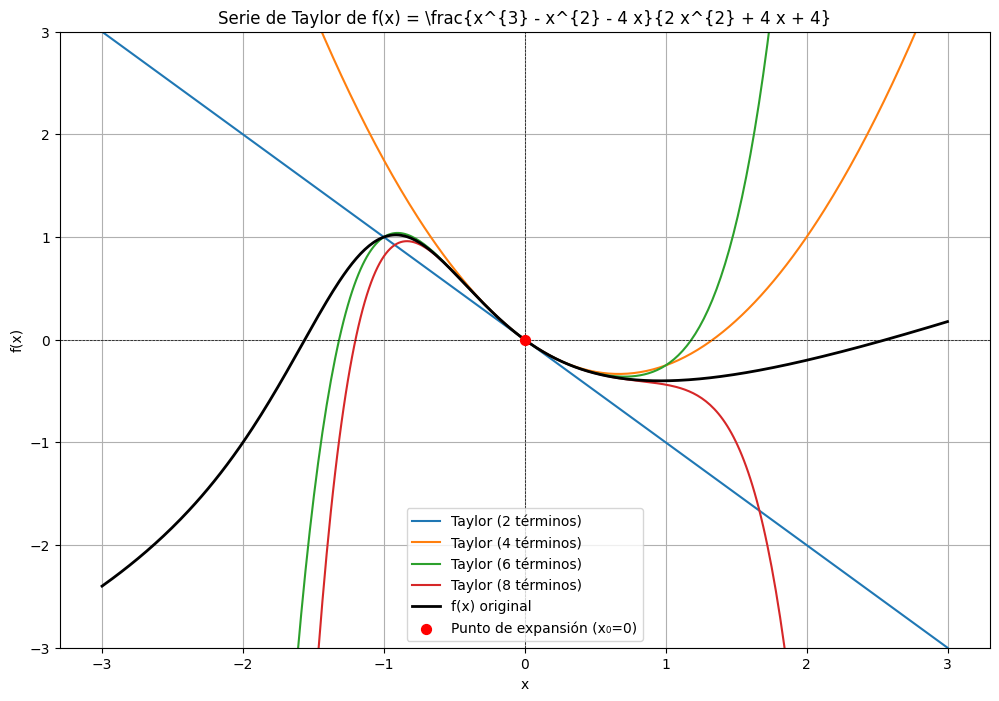


Error de aproximación en puntos específicos:


,x,Error (2 términos),Error (4 términos),Error (6 términos),Error (8 términos)
0,-2,3.0,6.00,12.00,24.0000
1,-1,0.0,0.75,0.00,0.1875
2,0,0.0,0.00,0.00,0.0000
3,1,0.6,0.15,0.15,0.0375
4,2,1.8,1.20,7.20,4.8000


In [22]:
# Define the rational function
expr = "(x**3 - x**2 - 4*x)/(2*x**2 + 4*x + 4)"

# Create Taylor series object
taylor = TaylorSeries(expr, expansion_point=0)

# Calculate coefficients
taylor.calculate_coefficients(max_terms=8)

# Print original function
print("Función original:")
display(Math(f"f(x) = {sp.latex(taylor.f_sym)}"))

# Display table of coefficients
print("\nTabla de coeficientes y derivadas:")
df_coeffs = taylor.display_coefficients_table()
display(df_coeffs)

# Display Taylor series formulas for different orders
print("\nFórmulas de la serie de Taylor:")
n_terms_list = [2, 4, 6, 8]
for n in n_terms_list:
    formula = taylor.get_latex_formula(n)
    print(f"\nPolinomio de Taylor con {n} términos:")
    display(Math(f"P_{n}(x) = {formula}"))

# Plot the approximations
fig = taylor.plot_approximations(ylim=(-3, 3))
plt.show()

# Calculate error at specific points
test_points = [-2, -1, 0, 1, 2]
print("\nError de aproximación en puntos específicos:")
error_df = taylor.calculate_error(test_points)
display(error_df)

## Fourier

In [23]:
class FourierSeries:
    """
    A class to calculate and visualize Fourier series approximations for any function.
    """
    def __init__(self, function_expr, variable=None, period=2*np.pi, interval=None):
        """
        Initialize with a symbolic function expression.
        
        Parameters:
        -----------
        function_expr : str, sympy expression, or callable
            The function to approximate with Fourier series
        variable : sympy.Symbol, optional
            The variable symbol to use (defaults to 'x' if None)
        period : float, optional
            Period of the function (default 2π)
        interval : tuple, optional
            Interval [a,b] for the Fourier series (default is [-period/2, period/2])
        """
        if variable is None:
            self.x_sym = sp.Symbol('x')
        else:
            self.x_sym = variable
            
        # Store the period and calculate interval
        self.period = period
        if interval is None:
            self.interval = (-period/2, period/2)
        else:
            self.interval = interval
            
        # Convert function to different formats
        if isinstance(function_expr, str):
            self.f_sym = sp.sympify(function_expr)
            self.f_callable = sp.lambdify(self.x_sym, self.f_sym, 'numpy')
        elif isinstance(function_expr, sp.Expr):
            self.f_sym = function_expr
            self.f_callable = sp.lambdify(self.x_sym, self.f_sym, 'numpy')
        else:  # Assume it's already a callable function
            self.f_callable = function_expr
            # We'll create a dummy symbolic representation
            self.f_sym = function_expr
            
        # Will store the coefficients once calculated
        self.a_coeffs = []
        self.b_coeffs = []
        self.fourier_terms = 0
        self.formula = None
        
    def calculate_coefficients(self, num_terms=8):
        """
        Calculate Fourier series coefficients up to the specified number of terms.
        
        Parameters:
        -----------
        num_terms : int
            Number of terms in the Fourier series (not counting a_0)
        """
        a, b = self.interval
        L = (b - a) / 2  # Half the interval length
        
        # Reset coefficients
        self.a_coeffs = []
        self.b_coeffs = []
        
        # Calculate a_0 (constant term)
        try:
            # Try using sympy for exact integration
            integrand = self.f_sym
            a0 = float(sp.integrate(integrand, (self.x_sym, a, b)) / (b - a))
        except:
            # Fallback to numerical integration
            def integrand(x):
                try:
                    return self.f_callable(x)
                except:
                    return float(self.f_sym.subs(self.x_sym, x))
                    
            a0, _ = quad(integrand, a, b)
            a0 = a0 / (b - a)
            
        self.a_coeffs.append(a0)
        
        # Calculate a_n and b_n coefficients
        for n in range(1, num_terms + 1):
            # a_n coefficient
            try:
                integrand = self.f_sym * sp.cos(n * sp.pi * (self.x_sym - a) / L)
                an = float(sp.integrate(integrand, (self.x_sym, a, b)) * (2 / (b - a)))
            except:
                def integrand_an(x):
                    try:
                        return self.f_callable(x) * np.cos(n * np.pi * (x - a) / L)
                    except:
                        return float(self.f_sym.subs(self.x_sym, x)) * np.cos(n * np.pi * (x - a) / L)
                        
                an, _ = quad(integrand_an, a, b)
                an = an * (2 / (b - a))
                
            self.a_coeffs.append(an)
            
            # b_n coefficient
            try:
                integrand = self.f_sym * sp.sin(n * sp.pi * (self.x_sym - a) / L)
                bn = float(sp.integrate(integrand, (self.x_sym, a, b)) * (2 / (b - a)))
            except:
                def integrand_bn(x):
                    try:
                        return self.f_callable(x) * np.sin(n * np.pi * (x - a) / L)
                    except:
                        return float(self.f_sym.subs(self.x_sym, x)) * np.sin(n * np.pi * (x - a) / L)
                        
                bn, _ = quad(integrand_bn, a, b)
                bn = bn * (2 / (b - a))
                
            self.b_coeffs.append(bn)
        
        self.fourier_terms = num_terms
        
        # Create symbolic formula
        x = self.x_sym
        a_val = self.interval[0]
        L_val = L
        
        self.formula = self.a_coeffs[0] / 2
        for n in range(1, num_terms + 1):
            self.formula += self.a_coeffs[n] * sp.cos(n * sp.pi * (x - a_val) / L_val)
            self.formula += self.b_coeffs[n-1] * sp.sin(n * sp.pi * (x - a_val) / L_val)
            
        return self.a_coeffs, self.b_coeffs
    
    def get_approximation_function(self, terms=None):
        """
        Returns a callable function for the Fourier approximation.
        
        Parameters:
        -----------
        terms : int or None
            Number of terms to include (if None, use all calculated terms)
        """
        if terms is None:
            terms = self.fourier_terms
        else:
            terms = min(terms, self.fourier_terms)
            
        a_coeffs = self.a_coeffs[:terms+1]  # Include a_0
        b_coeffs = self.b_coeffs[:terms]    # b starts at b_1
        
        a, b = self.interval
        L = (b - a) / 2
        
        def fourier_approx(x):
            result = a_coeffs[0] / 2  # a_0/2 term
            
            for n in range(1, terms + 1):
                if n < len(a_coeffs):
                    result += a_coeffs[n] * np.cos(n * np.pi * (x - a) / L)
                if n-1 < len(b_coeffs):
                    result += b_coeffs[n-1] * np.sin(n * np.pi * (x - a) / L)
                    
            return result
            
        return fourier_approx
    
    def get_formula(self, terms=None):
        """
        Returns the symbolic formula for the Fourier series.
        
        Parameters:
        -----------
        terms : int or None
            Number of terms to include in the formula
        """
        if terms is None or self.formula is None:
            return self.formula
            
        x = self.x_sym
        a_val = self.interval[0]
        L_val = (self.interval[1] - self.interval[0]) / 2
        
        formula = self.a_coeffs[0] / 2
        for n in range(1, min(terms, self.fourier_terms) + 1):
            formula += self.a_coeffs[n] * sp.cos(n * sp.pi * (x - a_val) / L_val)
            formula += self.b_coeffs[n-1] * sp.sin(n * sp.pi * (x - a_val) / L_val)
            
        return formula
    
    def get_latex_formula(self, terms=None):
        """
        Returns LaTeX representation of the Fourier series.
        
        Parameters:
        -----------
        terms : int or None
            Number of terms to include in the LaTeX formula
        """
        formula = self.get_formula(terms)
        if formula:
            return sp.latex(formula)
        return ""
    
    def display_coefficients_table(self):
        """
        Display a table of Fourier coefficients.
        """
        data = {
            'n': list(range(len(self.a_coeffs))),
            'a_n': self.a_coeffs,
            'b_n': [0] + self.b_coeffs  # Add 0 for b_0 which doesn't exist
        }
        
        df = pd.DataFrame(data)
        display(df)
        return df
    
    def plot_approximations(self, x_range=None, num_points=1000, term_list=None, ylim=None):
        """
        Plot the original function and its Fourier approximations.
        
        Parameters:
        -----------
        x_range : tuple
            (min_x, max_x) range for plotting (default is the function interval)
        num_points : int
            Number of points to evaluate
        term_list : list
            List of approximation orders to plot
        ylim : tuple
            (min_y, max_y) for the plot
        """
        if x_range is None:
            # Extend the interval a bit for better visualization
            a, b = self.interval
            margin = (b - a) * 0.1
            x_range = (a - margin, b + margin)
            
        if term_list is None:
            term_list = [1, 3, 5, min(10, self.fourier_terms)]
            
        x = np.linspace(x_range[0], x_range[1], num_points)
        
        # Evaluate the original function
        try:
            y_actual = np.array([self.f_callable(xi) for xi in x])
        except:
            y_actual = np.zeros_like(x)
            for i, xi in enumerate(x):
                try:
                    y_actual[i] = float(self.f_sym.subs(self.x_sym, xi))
                except:
                    y_actual[i] = np.nan
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        
        # Plot the original function
        plt.plot(x, y_actual, 'k-', label='f(x) original', linewidth=2)
        
        # Plot each approximation
        for terms in term_list:
            if terms <= self.fourier_terms:
                approx_func = self.get_approximation_function(terms)
                y_approx = np.array([approx_func(xi) for xi in x])
                plt.plot(x, y_approx, label=f'Fourier ({terms} términos)')
        
        # Mark the interval boundaries
        plt.axvline(self.interval[0], color='gray', linestyle='--', alpha=0.7)
        plt.axvline(self.interval[1], color='gray', linestyle='--', alpha=0.7)
        
        # Add grid, legend, labels
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.title(f"Serie de Fourier para f(x)")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        
        if ylim:
            plt.ylim(ylim)
            
        return plt.gcf()
    
    def calculate_error(self, x_points, term_list=None):
        """
        Calculate error between approximation and actual function at specified points.
        
        Parameters:
        -----------
        x_points : list or array
            Points at which to calculate the error
        term_list : list
            List of term counts to evaluate
        """
        if term_list is None:
            term_list = [1, 3, 5, min(10, self.fourier_terms)]
            
        errors = {}
        
        # Calculate actual function values
        actual_values = {}
        for x in x_points:
            try:
                actual_values[x] = self.f_callable(x)
            except:
                try:
                    actual_values[x] = float(self.f_sym.subs(self.x_sym, x))
                except:
                    actual_values[x] = np.nan
        
        # Calculate errors for each term count
        for terms in term_list:
            if terms <= self.fourier_terms:
                approx_func = self.get_approximation_function(terms)
                errors[terms] = []
                
                for x in x_points:
                    if np.isnan(actual_values[x]):
                        errors[terms].append(np.nan)
                    else:
                        approx = approx_func(x)
                        error = abs(actual_values[x] - approx)
                        errors[terms].append(error)
        
        # Create DataFrame
        df = pd.DataFrame({'x': x_points})
        for terms in term_list:
            if terms in errors:
                df[f'Error ({terms} términos)'] = errors[terms]
                
        return df
    
    def visualize_convergence(self, x_point, max_terms=20):
        """
        Visualize how the Fourier approximation converges at a specific point.
        
        Parameters:
        -----------
        x_point : float
            Point at which to check convergence
        max_terms : int
            Maximum number of terms to include
        """
        # Calculate actual value
        try:
            actual = self.f_callable(x_point)
        except:
            actual = float(self.f_sym.subs(self.x_sym, x_point))
            
        # Calculate approximations with increasing terms
        terms = list(range(1, max_terms + 1))
        approximations = []
        errors = []
        
        for n in terms:
            if n <= self.fourier_terms:
                approx_func = self.get_approximation_function(n)
                approx = approx_func(x_point)
                approximations.append(approx)
                errors.append(abs(actual - approx))
            else:
                # Calculate more coefficients if needed
                old_terms = self.fourier_terms
                self.calculate_coefficients(n)
                approx_func = self.get_approximation_function(n)
                approx = approx_func(x_point)
                approximations.append(approx)
                errors.append(abs(actual - approx))
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot approximation values
        ax1.plot(terms, approximations, 'bo-')
        ax1.axhline(actual, color='r', linestyle='--', label=f'Valor exacto: {actual:.6f}')
        ax1.set_title(f'Convergencia en x = {x_point}')
        ax1.set_xlabel('Número de términos')
        ax1.set_ylabel('Valor de la aproximación')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot error values
        ax2.semilogy(terms, errors, 'ro-')
        ax2.set_title(f'Error de aproximación en x = {x_point}')
        ax2.set_xlabel('Número de términos')
        ax2.set_ylabel('Error (escala logarítmica)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

### Ejecutar

Coeficientes de la Serie de Fourier:


<IPython.core.display.Math object>

,n,a_n,b_n
0,0,-0.283517,0.000000
1,1,-0.645065,0.079873
2,2,-0.227394,-0.757029
3,3,0.118859,-0.277590
4,4,-0.033792,-0.165688
5,5,-0.014896,-0.179521
6,6,0.001265,-0.137288
7,7,-0.004439,-0.115761
8,8,-0.002986,-0.103400
9,9,-0.001829,-0.091307



Aproximaciones de la Serie de Fourier:


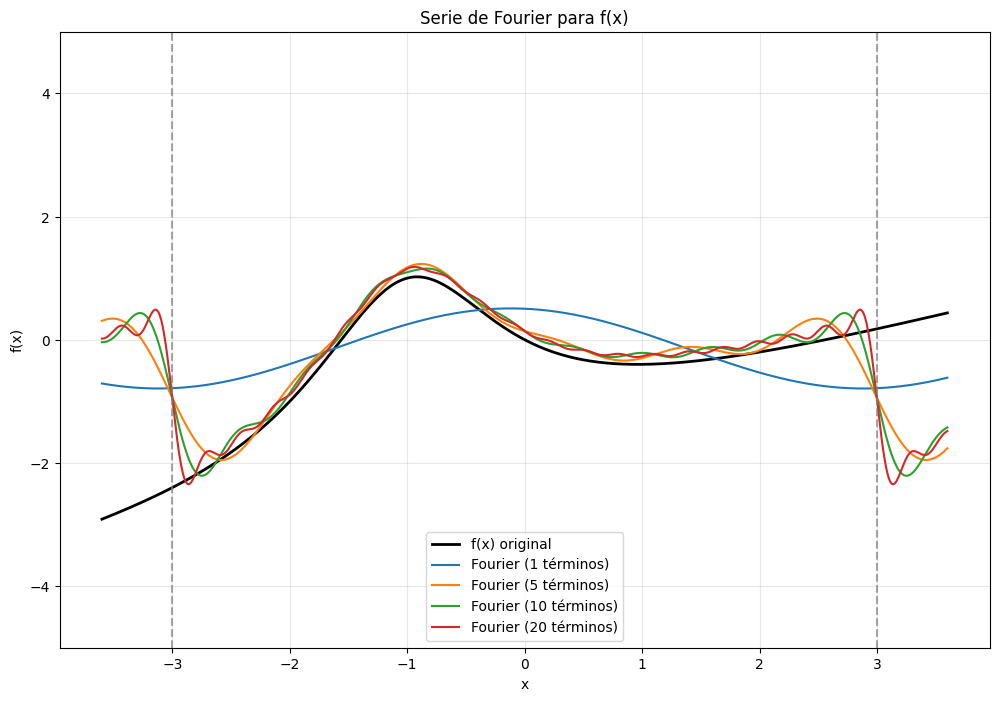


Error de aproximación en puntos específicos:


,x,Error (1 términos),Error (5 términos),Error (10 términos),Error (20 términos)
0,-3,1.613177,1.455954,1.446229,1.438333
1,-2,0.604881,0.252521,0.137031,0.107845
2,0,0.503307,0.138158,0.140968,0.141556
3,2,0.333463,0.027469,0.149428,0.175213
4,3,0.963294,1.120517,1.130241,1.138138



Convergencia de la serie de Fourier en un punto específico:


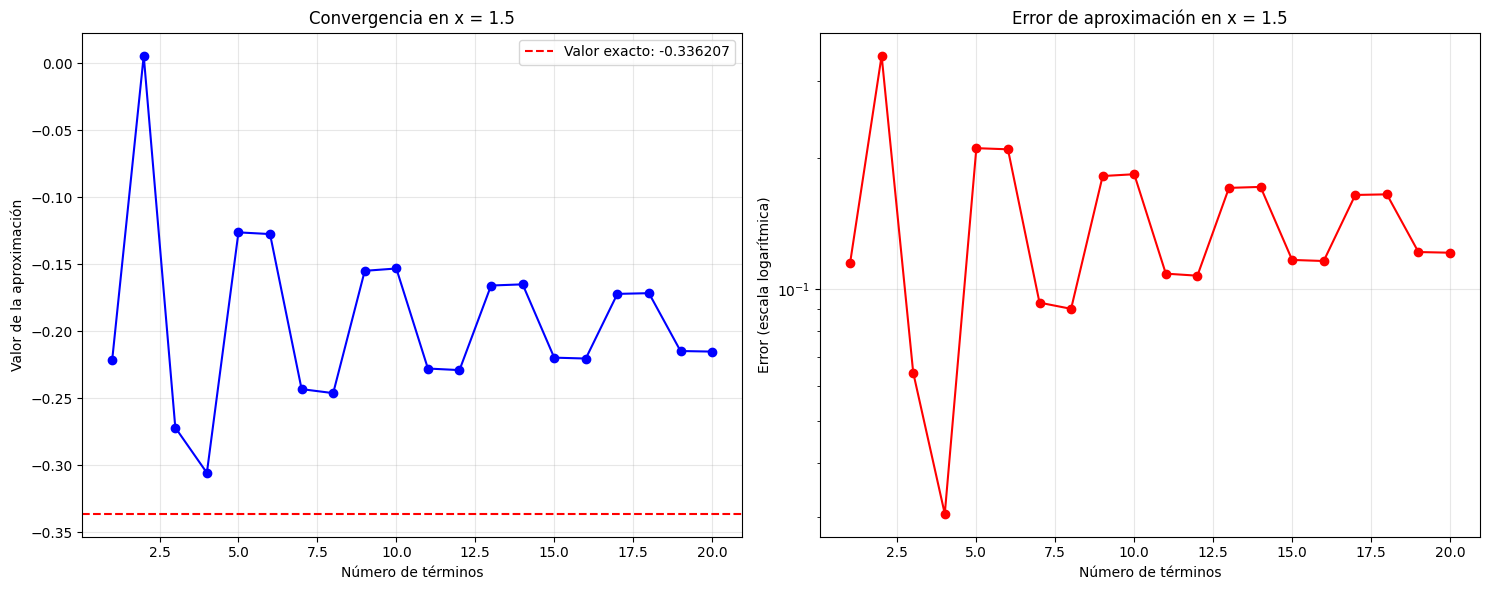


Fórmulas de la serie de Fourier para diferentes números de términos:

Serie de Fourier con 1 términos:


<IPython.core.display.Math object>


Serie de Fourier con 5 términos:


<IPython.core.display.Math object>


Serie de Fourier con 10 términos:


<IPython.core.display.Math object>


Serie de Fourier con 20 términos:


<IPython.core.display.Math object>

In [24]:
# Define la misma función racional que usamos para Taylor
expr = "(x**3 - x**2 - 4*x)/(2*x**2 + 4*x + 4)"

# Definimos un intervalo para el análisis de Fourier
interval = (-3, 3)

# Creamos el objeto de serie de Fourier
# Nota: el parámetro period no importa tanto porque definimos el intervalo directamente
fourier = FourierSeries(expr, interval=interval)

# Calculamos los coeficientes (usamos más términos para mejor aproximación)
fourier.calculate_coefficients(num_terms=20)

# Mostramos los coeficientes de Fourier
print("Coeficientes de la Serie de Fourier:")
display(Math(f"f(x) = {sp.latex(fourier.f_sym)}"))
fourier_coeffs = fourier.display_coefficients_table()

# Visualizamos las aproximaciones de Fourier
print("\nAproximaciones de la Serie de Fourier:")
fig = fourier.plot_approximations(term_list=[1, 5, 10, 20], ylim=(-5, 5))
plt.show()

# Calculamos el error en puntos específicos
test_points = [-3, -2, 0, 2, 3]  # Puntos dentro del intervalo
print("\nError de aproximación en puntos específicos:")
error_df = fourier.calculate_error(test_points, term_list=[1, 5, 10, 20])
display(error_df)

# Visualizamos la convergencia en un punto específico
print("\nConvergencia de la serie de Fourier en un punto específico:")
fig2 = fourier.visualize_convergence(x_point=1.5, max_terms=20)
plt.show()

# Comparamos fórmulas para diferentes números de términos
print("\nFórmulas de la serie de Fourier para diferentes números de términos:")
for terms in [1, 5, 10, 20]:
    formula = fourier.get_latex_formula(terms)
    print(f"\nSerie de Fourier con {terms} términos:")
    display(Math(f"F_{{{terms}}}(x) = {formula}"))

## Transformada Rápida de Fourier

In [25]:
class FastFourierTransform:
    """
    A class to calculate and visualize Fourier analysis using FFT for efficient computation.
    """
    def __init__(self, function=None, x_data=None, y_data=None, num_points=1024, domain=(-10, 10)):
        """
        Initialize with either a function or discrete data points.
        
        Parameters:
        -----------
        function : callable, optional
            Function to analyze with FFT
        x_data : array-like, optional
            x-coordinates of data points (if providing discrete data)
        y_data : array-like, optional
            y-coordinates of data points (if providing discrete data)
        num_points : int, optional
            Number of points to sample (if providing a function)
        domain : tuple, optional
            Domain (x_min, x_max) to sample function
        """
        self.domain = domain
        self.num_points = num_points
        
        # Process input data - either from function or discrete points
        if function is not None:
            # Sample the function
            self.x = np.linspace(domain[0], domain[1], num_points)
            self.y = np.array([function(xi) for xi in self.x])
        elif x_data is not None and y_data is not None:
            # Use provided data points
            self.x = np.array(x_data)
            self.y = np.array(y_data)
            self.num_points = len(self.x)
            self.domain = (min(self.x), max(self.x))
        else:
            raise ValueError("Either function or x_data/y_data must be provided")
            
        # Store attributes for frequency analysis
        self.frequencies = None
        self.amplitudes = None
        self.phases = None
        self.fft_result = None
        
    def compute_fft(self):
        """
        Compute the Fast Fourier Transform of the data.
        
        Returns:
        --------
        tuple: (frequencies, amplitudes, phases)
        """
        # Compute FFT
        fft_complex = np.fft.fft(self.y)
        
        # Normalize by number of points
        fft_complex = fft_complex / self.num_points
        
        # Compute frequency values
        sample_spacing = (self.domain[1] - self.domain[0]) / (self.num_points - 1)
        self.frequencies = np.fft.fftfreq(self.num_points, d=sample_spacing)
        
        # Calculate amplitudes and phases (only positive frequencies)
        self.amplitudes = np.abs(fft_complex)
        self.phases = np.angle(fft_complex)
        
        # Store full FFT result
        self.fft_result = fft_complex
        
        return self.frequencies, self.amplitudes, self.phases
    
    def get_dominant_frequencies(self, n=10):
        """
        Get the n most dominant frequencies in the signal.
        
        Parameters:
        -----------
        n : int
            Number of dominant frequencies to return
        
        Returns:
        --------
        DataFrame with frequency, amplitude, phase information
        """
        if self.frequencies is None:
            self.compute_fft()
            
        # Consider only positive frequencies (up to Nyquist frequency)
        pos_idx = np.arange(1, self.num_points // 2)
        
        # Get indices of top n amplitudes
        top_indices = np.argsort(self.amplitudes[pos_idx])[-n:][::-1]
        top_indices = pos_idx[top_indices]
        
        # Create DataFrame
        data = {
            'Frequency': self.frequencies[top_indices],
            'Amplitude': self.amplitudes[top_indices],
            'Phase (rad)': self.phases[top_indices]
        }
        
        return pd.DataFrame(data)
    
    def plot_spectrum(self, log_scale=False):
        """
        Plot the frequency spectrum.
        
        Parameters:
        -----------
        log_scale : bool
            Whether to use logarithmic scale for amplitude
        
        Returns:
        --------
        matplotlib figure
        """
        if self.frequencies is None:
            self.compute_fft()
        
        # Plot only up to Nyquist frequency (positive frequencies)
        freq_pos = self.frequencies[:self.num_points//2]
        amp_pos = self.amplitudes[:self.num_points//2]
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Plot frequency spectrum
        if log_scale:
            # Add small value to avoid log(0)
            ax.semilogy(freq_pos, amp_pos + 1e-10)
            ax.set_ylabel('Amplitud (escala logarítmica)')
        else:
            ax.plot(freq_pos, amp_pos)
            ax.set_ylabel('Amplitud')
            
        ax.set_xlabel('Frecuencia')
        ax.set_title('Espectro de Frecuencias')
        ax.grid(True, alpha=0.3)
        
        return fig
    
    def reconstruct_signal(self, num_components=None):
        """
        Reconstruct the signal using inverse FFT, optionally with limited components.
        
        Parameters:
        -----------
        num_components : int or None
            Number of frequency components to use (None = all components)
            
        Returns:
        --------
        reconstructed signal values
        """
        if self.fft_result is None:
            self.compute_fft()
            
        # If using all components, just use the original FFT result
        if num_components is None or num_components >= self.num_points//2:
            reconstructed_fft = self.fft_result
        else:
            # Start with zeros
            reconstructed_fft = np.zeros_like(self.fft_result, dtype=complex)
            
            # Keep DC component (frequency=0)
            reconstructed_fft[0] = self.fft_result[0]
            
            # Find indices of dominant frequencies (excluding DC)
            pos_idx = np.arange(1, self.num_points // 2)
            top_indices = np.argsort(self.amplitudes[pos_idx])[-num_components:]
            top_indices = pos_idx[top_indices]
            
            # Set these components in both positive and negative frequencies (complex conjugates)
            reconstructed_fft[top_indices] = self.fft_result[top_indices]
            reconstructed_fft[self.num_points - top_indices] = self.fft_result[self.num_points - top_indices]
            
        # Perform inverse FFT and scale
        reconstructed_signal = np.real(np.fft.ifft(reconstructed_fft * self.num_points))
        
        return reconstructed_signal
    
    def plot_reconstructions(self, component_list=None):
        """
        Plot original signal and reconstructions with different numbers of components.
        
        Parameters:
        -----------
        component_list : list
            List of number of components to use for reconstructions
            
        Returns:
        --------
        matplotlib figure
        """
        if component_list is None:
            component_list = [1, 5, 10, 20]
            
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot original signal
        ax.plot(self.x, self.y, 'k', label='Señal original', linewidth=2)
        
        # Plot reconstructions
        for n in component_list:
            reconstructed = self.reconstruct_signal(n)
            ax.plot(self.x, reconstructed, label=f'Reconstrucción ({n} componentes)')
            
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title('Señal Original y Reconstrucciones con FFT')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        return fig
    
    def compare_with_fourier_series(self, fourier_series, component_list=None):
        """
        Compare FFT reconstruction with traditional Fourier series.
        
        Parameters:
        -----------
        fourier_series : FourierSeries object
            Traditional Fourier series to compare with
        component_list : list
            List of number of components to use for comparison
            
        Returns:
        --------
        matplotlib figure
        """
        if component_list is None:
            component_list = [5, 10]
            
        fig, axs = plt.subplots(len(component_list), 1, figsize=(12, 4*len(component_list)))
        if len(component_list) == 1:
            axs = [axs]
            
        for i, n in enumerate(component_list):
            # Get reconstructions
            fft_recon = self.reconstruct_signal(n)
            
            # Plot original and FFT reconstruction
            axs[i].plot(self.x, self.y, 'k', label='Original', linewidth=2)
            axs[i].plot(self.x, fft_recon, 'r--', label=f'FFT ({n} componentes)')
            
            # Plot Fourier series if available
            if fourier_series is not None and fourier_series.fourier_terms >= n:
                fourier_approx = fourier_series.get_approximation_function(terms=n)
                y_fourier = [fourier_approx(xi) for xi in self.x]
                axs[i].plot(self.x, y_fourier, 'g-.', label=f'Serie Fourier ({n} términos)')
                
            axs[i].set_title(f'Comparación con {n} componentes')
            axs[i].grid(True, alpha=0.3)
            axs[i].legend()
            
        fig.tight_layout()
        return fig
    
    def calculate_error(self, component_list=None):
        """
        Calculate reconstruction error for different numbers of components.
        
        Parameters:
        -----------
        component_list : list
            List of number of components to use
            
        Returns:
        --------
        DataFrame with errors
        """
        if component_list is None:
            component_list = [1, 2, 5, 10, 20, 50, 100]
            
        errors = []
        
        for n in component_list:
            reconstructed = self.reconstruct_signal(n)
            mse = np.mean((self.y - reconstructed)**2)
            max_error = np.max(np.abs(self.y - reconstructed))
            errors.append((n, mse, max_error))
            
        df = pd.DataFrame(errors, columns=['Componentes', 'Error cuadrático medio', 'Error máximo'])
        return df
    
    def get_analytic_formula(self, num_components=None):
        """
        Obtiene una fórmula analítica aproximada a partir de los resultados de la FFT.
        
        Parameters:
        -----------
        num_components : int
            Número de componentes de frecuencia a incluir
            
        Returns:
        --------
        sympy expression
            Expresión simbólica de la aproximación
        """
        if self.frequencies is None:
            self.compute_fft()
            
        if num_components is None:
            # Usa un número razonable de componentes
            num_components = min(20, self.num_points//2)
        
        # Encuentra las frecuencias dominantes (excluyendo el componente DC)
        pos_idx = np.arange(1, self.num_points // 2)
        indices = np.argsort(self.amplitudes[pos_idx])[-num_components:][::-1]
        indices = pos_idx[indices]
        
        # Incluye también el componente DC (frecuencia 0)
        dc_component = self.fft_result[0].real
        
        # Crea la fórmula simbólica usando sympy
        x = sp.Symbol('x')
        formula = dc_component  # Componente DC
        
        for idx in indices:
            freq = self.frequencies[idx]
            amplitude = abs(self.fft_result[idx])
            phase = np.angle(self.fft_result[idx])
            
            # Cada componente es: amplitude * cos(2π * freq * x + phase)
            term = amplitude * sp.cos(2 * sp.pi * freq * x + phase)
            formula += term
        
        return formula
    
    def get_latex_formula(self, num_components=None):
        """
        Obtiene la representación LaTeX de la fórmula analítica.
        
        Parameters:
        -----------
        num_components : int
            Número de componentes de frecuencia a incluir
            
        Returns:
        --------
        str
            Representación LaTeX de la fórmula
        """
        formula = self.get_analytic_formula(num_components)
        return sp.latex(formula)
    
    def get_callable_function(self, num_components=None):
        """
        Obtiene una función Python que implementa la aproximación FFT.
        
        Parameters:
        -----------
        num_components : int
            Número de componentes de frecuencia a incluir
            
        Returns:
        --------
        callable
            Función que implementa la aproximación
        """
        if self.frequencies is None:
            self.compute_fft()
            
        if num_components is None:
            num_components = min(20, self.num_points//2)
        
        # Encuentra las frecuencias dominantes (excluyendo el componente DC)
        pos_idx = np.arange(1, self.num_points // 2)
        indices = np.argsort(self.amplitudes[pos_idx])[-num_components:][::-1]
        indices = pos_idx[indices]
        
        # Guarda los datos necesarios para la función
        dc_component = self.fft_result[0].real
        frequencies = [self.frequencies[idx] for idx in indices]
        amplitudes = [abs(self.fft_result[idx]) for idx in indices]
        phases = [np.angle(self.fft_result[idx]) for idx in indices]
        
        # Define la función de aproximación
        def fourier_approximation(x):
            result = dc_component  # Componente DC
            
            for i in range(len(frequencies)):
                # Cada componente es: amplitude * cos(2π * freq * x + phase)
                result += amplitudes[i] * np.cos(2 * np.pi * frequencies[i] * x + phases[i])
                
            return result
        
        return fourier_approximation

### Ejecutar

Frecuencias dominantes en la función racional:


,Frequency,Amplitude,Phase (rad)
0,0.199902,0.651674,1.454505
1,0.099951,0.648237,2.281302
2,0.399805,0.248683,1.834541
3,0.499756,0.161238,1.329570
4,0.299854,0.131356,1.254758
5,0.699658,0.122697,1.556576
6,0.599707,0.118917,1.735072
7,0.799609,0.091776,1.566975
8,0.899561,0.088807,1.618454
9,0.999512,0.078130,1.567043



Espectro de frecuencias:


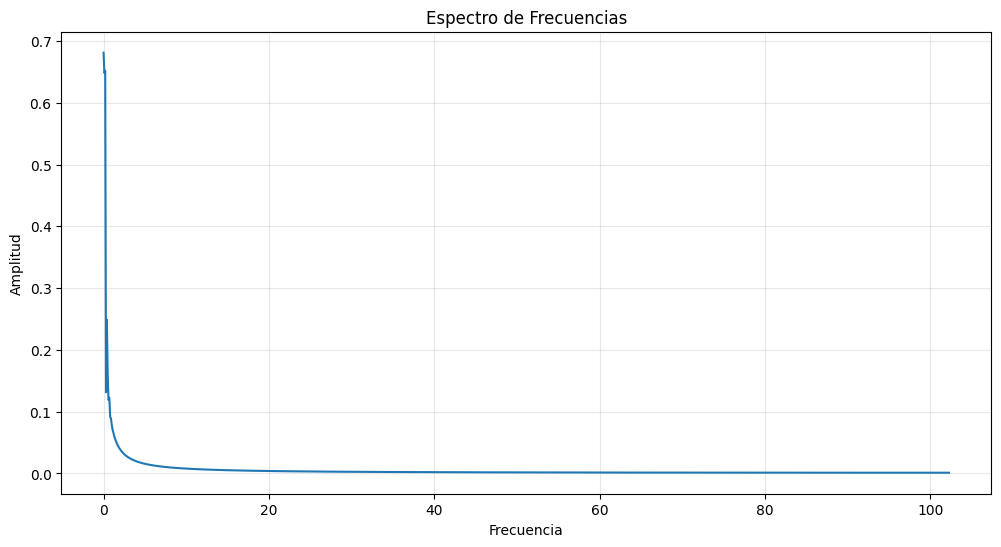


Reconstrucciones con diferentes números de componentes:


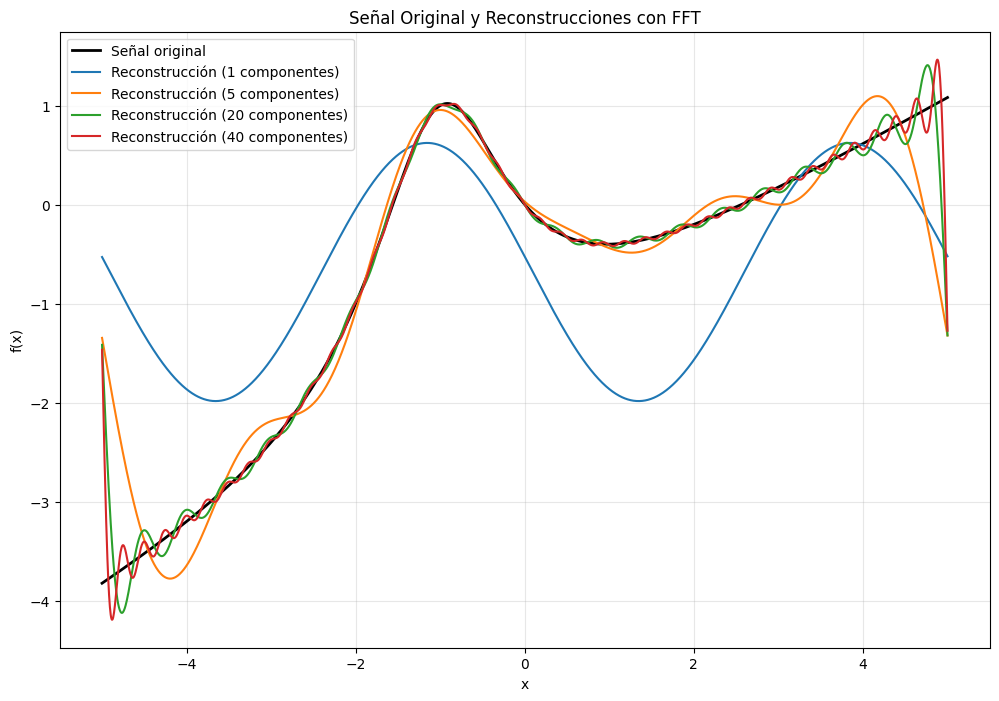


Errores de reconstrucción:


,Componentes,Error cuadrático medio,Error máximo
0,1,1.269862,3.293858
1,2,0.429439,2.448275
2,5,0.219248,2.477303
3,10,0.116029,2.434724
4,20,0.059480,2.407045
5,50,0.024108,2.333561
6,100,0.012042,2.213215


In [29]:
# Define the same rational function
expr = "(x**3 - x**2 - 4*x)/(2*x**2 + 4*x + 4)"

# Create a callable function for the expression
x_sym = sp.Symbol('x')
f_sym = sp.sympify(expr)
f = sp.lambdify(x_sym, f_sym, 'numpy')

# Create the FFT analyzer
fft_analyzer = FastFourierTransform(function=f, domain=(-5, 5), num_points=2048)

# Compute FFT
fft_analyzer.compute_fft()

# Display dominant frequencies
print("Frecuencias dominantes en la función racional:")
dominant_freq_df = fft_analyzer.get_dominant_frequencies(n=20)
display(dominant_freq_df)

# Plot frequency spectrum
print("\nEspectro de frecuencias:")
fig_spectrum = fft_analyzer.plot_spectrum()
plt.show()

# Plot reconstructions
print("\nReconstrucciones con diferentes números de componentes:")
fig_recon = fft_analyzer.plot_reconstructions(component_list=[1, 5, 20, 40])
plt.show()

# Calculate and display errors
print("\nErrores de reconstrucción:")
error_df = fft_analyzer.calculate_error()
display(error_df)

# Problema 26

## Interpolación de Newton

In [2]:
class NewtonInterpolation:
    """
    A class to perform Newton's interpolation method for polynomial fitting.
    """
    def __init__(self, x_points=None, y_points=None):
        """
        Initialize with optional data points.
        
        Parameters:
        -----------
        x_points : array-like, optional
            x coordinates of data points
        y_points : array-like, optional
            y coordinates of data points
        """
        self.x = None
        self.y = None
        self.coefficients = None
        self.divided_differences = None
        
        if x_points is not None and y_points is not None:
            self.set_points(x_points, y_points)
    
    def set_points(self, x_points, y_points):
        """
        Set the data points to interpolate.
        
        Parameters:
        -----------
        x_points : array-like
            x coordinates of data points
        y_points : array-like
            y coordinates of data points
        """
        if len(x_points) != len(y_points):
            raise ValueError("x_points and y_points must have the same length")
            
        self.x = np.array(x_points, dtype=float)
        self.y = np.array(y_points, dtype=float)
        self.coefficients = None  # Reset coefficients
        self.divided_differences = None  # Reset divided differences
    
    def compute_divided_differences(self):
        """
        Compute the divided differences table for Newton interpolation.
        
        Returns:
        --------
        numpy.ndarray
            Table of divided differences
        """
        n = len(self.x)
        # Initialize divided differences table
        # Each row represents a level of differences
        table = np.zeros((n, n))
        
        # First column is y values
        table[:, 0] = self.y
        
        # Calculate divided differences
        for j in range(1, n):
            for i in range(n - j):
                table[i, j] = (table[i+1, j-1] - table[i, j-1]) / (self.x[i+j] - self.x[i])
        
        self.divided_differences = table
        
        # Extract coefficients (first row of divided differences table)
        self.coefficients = table[0, :]
        
        return table
    
    def evaluate(self, x_eval):
        """
        Evaluate the Newton interpolation polynomial at given points.
        
        Parameters:
        -----------
        x_eval : float or array-like
            Points at which to evaluate the polynomial
        
        Returns:
        --------
        float or numpy.ndarray
            Value(s) of the polynomial at x_eval
        """
        if self.coefficients is None:
            self.compute_divided_differences()
            
        # Convert input to numpy array if it's a scalar
        scalar_input = np.isscalar(x_eval)
        x_array = np.array([x_eval]) if scalar_input else np.array(x_eval)
        
        n = len(self.x)
        result = np.zeros_like(x_array, dtype=float)
        
        for i in range(len(x_array)):
            # Start with the constant term (first coefficient)
            temp = self.coefficients[n-1]
            
            # Build up the polynomial using Horner's method
            for j in range(n-2, -1, -1):
                temp = temp * (x_array[i] - self.x[j]) + self.coefficients[j]
                
            result[i] = temp
            
        return result[0] if scalar_input else result
    
    def get_polynomial_terms(self):
        """
        Get the terms of the Newton form polynomial.
        
        Returns:
        --------
        list of strings
            Terms of the Newton polynomial in readable form
        """
        if self.coefficients is None:
            self.compute_divided_differences()
            
        terms = []
        
        # First term is just the constant coefficient
        terms.append(f"{self.coefficients[0]:.6g}")
        
        # Build up remaining terms
        for i in range(1, len(self.coefficients)):
            if self.coefficients[i] == 0:
                continue  # Skip zero coefficients
                
            term = f"{self.coefficients[i]:.6g}"
            
            # Multiply by (x - x_j) factors
            for j in range(i):
                x_j = self.x[j]
                if x_j >= 0:
                    term += f"(x - {x_j})"
                else:
                    term += f"(x + {-x_j})"
                
            terms.append(term)
            
        return terms
    
    def get_polynomial_string(self):
        """
        Get the Newton interpolation polynomial as a readable string.
        
        Returns:
        --------
        str
            String representation of the Newton polynomial
        """
        terms = self.get_polynomial_terms()
        
        # Join terms with appropriate signs
        polynomial = terms[0]
        for term in terms[1:]:
            if term.startswith('-'):
                polynomial += f" {term}"
            else:
                polynomial += f" + {term}"
                
        return polynomial
    
    def get_standard_form_symbolic(self):
        """
        Convert the Newton form to standard form using sympy.
        
        Returns:
        --------
        sympy expression
            Standard form of the polynomial
        """
        # Create symbolic variable
        x = sp.Symbol('x')
        
        # Build Newton form symbolically
        polynomial = self.coefficients[0]
        product = 1
        
        for i in range(1, len(self.coefficients)):
            product *= (x - self.x[i-1])
            polynomial += self.coefficients[i] * product
            
        # Expand to standard form
        expanded_poly = sp.expand(polynomial)
        
        return expanded_poly
    
    def get_standard_form_string(self):
        """
        Get the standard form of the polynomial as a string.
        
        Returns:
        --------
        str
            String representation of the polynomial in standard form
        """
        expanded_poly = self.get_standard_form_symbolic()
        return str(expanded_poly)
    
    def get_standard_form_latex(self):
        """
        Get the standard form of the polynomial in LaTeX format.
        
        Returns:
        --------
        str
            LaTeX representation of the polynomial in standard form
        """
        expanded_poly = self.get_standard_form_symbolic()
        return sp.latex(expanded_poly)
    
    def plot_interpolation(self, x_range=None, num_points=1000):
        """
        Plot the data points and the interpolation polynomial.
        
        Parameters:
        -----------
        x_range : tuple, optional
            Range (x_min, x_max) for plotting the polynomial
        num_points : int, optional
            Number of points to use for plotting the smooth curve
        
        Returns:
        --------
        matplotlib figure
        """
        if self.coefficients is None:
            self.compute_divided_differences()
            
        if x_range is None:
            # Extend range slightly beyond data points
            x_min, x_max = min(self.x), max(self.x)
            margin = (x_max - x_min) * 0.1
            x_range = (x_min - margin, x_max + margin)
            
        # Generate points for smooth curve
        x_curve = np.linspace(x_range[0], x_range[1], num_points)
        y_curve = self.evaluate(x_curve)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot the data points
        ax.scatter(self.x, self.y, color='red', s=50, label='Puntos de datos')
        
        # Plot the interpolation curve
        ax.plot(x_curve, y_curve, 'b-', label='Polinomio de interpolación')
        
        # Add grid and labels
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Interpolación de Newton')
        ax.legend()
        
        return fig
    
    def display_divided_differences_table(self):
        """
        Display the divided differences table in a formatted way.
        
        Returns:
        --------
        pandas DataFrame
            Table of divided differences
        """
        if self.divided_differences is None:
            self.compute_divided_differences()
            
        n = len(self.x)
        
        # Create a DataFrame for better display
        columns = ['y'] + [f'Δ^{i}' for i in range(1, n)]
        index = [f'x_{i} = {self.x[i]}' for i in range(n)]
        
        # Only include the relevant part of the divided differences table
        table_data = np.zeros((n, n))
        for i in range(n):
            table_data[i, 0:n-i] = self.divided_differences[i, 0:n-i]
            
        df = pd.DataFrame(table_data, index=index, columns=columns)

        # Prints the df in a markdown table format in the file: div_diff.md
        with open('div_diff.md', 'w') as f:
            f.write(df.to_markdown())
        
        return df
    
    def get_error_bounds(self, x_eval):
        """
        Estimate error bounds for the interpolation at given points.
        
        Note: This assumes the function being interpolated has continuous derivatives
        up to the n-th order, where n is the degree of the polynomial.
        
        Parameters:
        -----------
        x_eval : float or array-like
            Points at which to estimate error bounds
        
        Returns:
        --------
        float or numpy.ndarray
            Estimated upper bounds of the error
        """
        if self.coefficients is None:
            self.compute_divided_differences()
            
        n = len(self.x)
        
        # Convert input to numpy array if it's a scalar
        scalar_input = np.isscalar(x_eval)
        x_array = np.array([x_eval]) if scalar_input else np.array(x_eval)
        
        error_bounds = np.zeros_like(x_array, dtype=float)
        
        for i in range(len(x_array)):
            # Calculate product term (x - x_0)(x - x_1)...(x - x_{n-1})
            product = 1.0
            for j in range(n):
                product *= (x_array[i] - self.x[j])
                
            # Estimate error using the last divided difference as approximation
            # of the n-th derivative divided by n!
            error_bounds[i] = abs(product * self.divided_differences[0, n-1])
            
        return error_bounds[0] if scalar_input else error_bounds

Tabla de diferencias divididas:


,y,Δ^1,Δ^2,Δ^3,Δ^4,Δ^5,Δ^6,Δ^7,Δ^8,Δ^9,Δ^10,Δ^11,Δ^12
x_0 = 2.0,5.0,10.370370,-5.325587,1.309294,-0.218100,2.743874e-02,-0.002516,0.000183,-1.191371e-05,6.871415e-07,-3.444939e-08,1.467606e-09,-5.210230e-11
x_1 = 2.27,7.8,0.784314,-0.088410,0.000697,0.001410,-2.356786e-04,0.000040,-0.000008,1.141981e-06,-1.051944e-07,6.643596e-09,-3.038717e-10,0.000000e+00
x_2 = 3.8,9.0,0.454545,-0.084416,0.011599,-0.001118,3.120446e-04,-0.000087,0.000013,-1.249087e-06,7.903254e-08,-3.605998e-09,0.000000e+00,0.000000e+00
x_3 = 6.0,10.0,0.100000,-0.012500,0.001310,0.002688,-9.231151e-04,0.000142,-0.000013,8.215657e-07,-3.708058e-08,0.000000e+00,0.000000e+00,0.000000e+00
x_4 = 8.0,10.2,0.050000,-0.003333,0.028194,-0.008389,1.209596e-03,-0.000108,0.000007,-2.908519e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
x_5 = 10.0,10.3,0.033333,0.222222,-0.055694,0.007336,-6.230960e-04,0.000037,-0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
x_6 = 13.0,10.4,1.366667,-0.223333,0.025000,-0.002011,1.073763e-04,-0.000005,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
x_7 = 16.0,14.5,0.250000,-0.023333,0.000873,-0.000185,5.210839e-07,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
x_8 = 18.0,15.0,0.133333,-0.015476,-0.001720,-0.000175,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
x_9 = 21.0,15.4,0.025000,-0.036111,-0.004865,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00



Polinomio de interpolación (forma de Newton):
5 + 10.3704(x - 2.0) -5.32559(x - 2.0)(x - 2.27) + 1.30929(x - 2.0)(x - 2.27)(x - 3.8) -0.2181(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0) + 0.0274387(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0) -0.00251586(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0) + 0.000182553(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0)(x - 13.0) -1.19137e-05(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0)(x - 13.0)(x - 16.0) + 6.87141e-07(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0)(x - 13.0)(x - 16.0)(x - 18.0) -3.44494e-08(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0)(x - 13.0)(x - 16.0)(x - 18.0)(x - 21.0) + 1.46761e-09(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0)(x - 13.0)(x - 16.0)(x - 18.0)(x - 21.0)(x - 25.0) -5.21023e-11(x - 2.0)(x - 2.27)(x - 3.8)(x - 6.0)(x - 8.0)(x - 10.0)(x - 13.0)(x - 16.0)(x - 18.0)(x - 21.0)(x - 25.0)(x - 30.0)

Polinomio de interpolación (forma estándar):
-5.21023006438643e-11*

<IPython.core.display.Math object>


Gráfica de la interpolación:


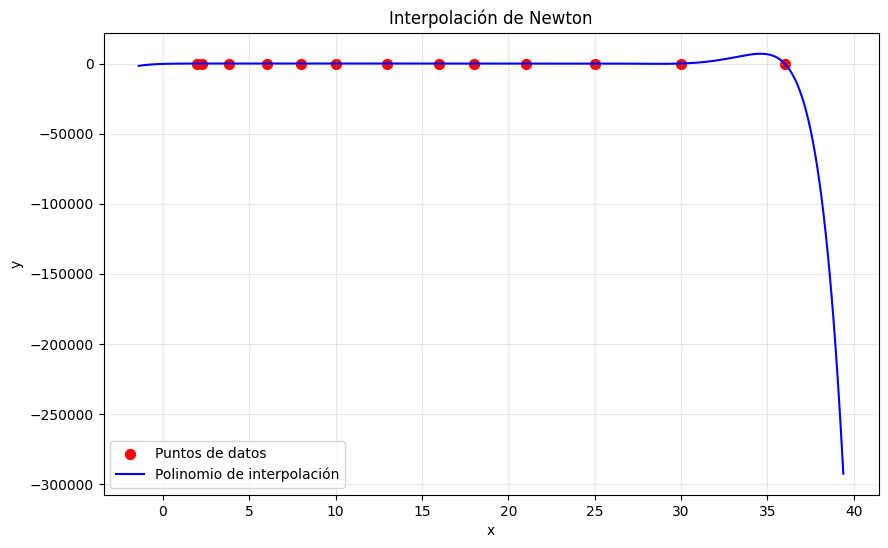


Evaluación del polinomio en puntos específicos:
P(1.5) = -8.070811452183753
P(2.5) = 8.931728756991895
P(3.5) = 9.138625114805436
P(4.5) = 9.10109636997181

Estimación de cotas de error:
Error en x = 1.5: ≤ 14.220225315711051
Error en x = 2.5: ≤ 0.9474942947111792
Error en x = 3.5: ≤ 1.1766512727445917
Error en x = 4.5: ≤ 2.1050425520771476


In [8]:
# Given data points
x_points = [2, 2.27, 3.8, 6, 8, 10, 13, 16, 18, 21, 25, 30, 36]
y_points = [5, 7.8, 9, 10, 10.2, 10.3, 10.4, 14.5, 15, 15.4, 15.5, 14, 5]

# Create Newton interpolation object
newton = NewtonInterpolation(x_points, y_points)

# Compute divided differences
newton.compute_divided_differences()

# Display divided differences table
print("Tabla de diferencias divididas:")
dd_table = newton.display_divided_differences_table()
display(dd_table)

# Get the polynomial in Newton form
print("\nPolinomio de interpolación (forma de Newton):")
newton_form = newton.get_polynomial_string()
print(newton_form)

# Get the polynomial in standard form
print("\nPolinomio de interpolación (forma estándar):")
standard_form = newton.get_standard_form_string()
print(standard_form)

# Display the polynomial in LaTeX format
print("\nPolinomio de interpolación (forma estándar en LaTeX):")
latex_form = newton.get_standard_form_latex()
display(Math(latex_form))

# Plot the interpolation
print("\nGráfica de la interpolación:")
fig = newton.plot_interpolation()
plt.show()

# Evaluate the polynomial at specific points
test_points = [1.5, 2.5, 3.5, 4.5]
print("\nEvaluación del polinomio en puntos específicos:")
for x in test_points:
    y = newton.evaluate(x)
    print(f"P({x}) = {y}")

# Estimate error bounds
print("\nEstimación de cotas de error:")
error_bounds = newton.get_error_bounds(test_points)
for i, x in enumerate(test_points):
    print(f"Error en x = {x}: ≤ {error_bounds[i]}")

Polinomio de Simétrico 1 (forma de Newton):
5 + 0.4(x - 0.0) -1.2(x - 0.0)(x + 0.5)

Polinomio de Simétrico 1 (forma estándar):
-1.2*x**2 - 0.199999999999999*x + 5.0

--------------------------------------------------------------------------------

Polinomio de Simétrico 2 (forma de Newton):
4 + 6.66667(x + 1.0) -6.66667(x + 1.0)(x + 1.3)

Polinomio de Simétrico 2 (forma estándar):
-6.66666666666667*x**2 - 8.66666666666668*x + 1.99999999999999

--------------------------------------------------------------------------------

Polinomio de Simétrico 3 (forma de Newton):
4 -1.25(x + 1.0) -0.0625(x + 1.0)(x + 5.0) -0.00803571(x + 1.0)(x + 5.0)(x + 13.0)

Polinomio de Simétrico 3 (forma estándar):
-0.00803571428571429*x**3 - 0.215178571428571*x**2 - 2.29196428571429*x + 1.91517857142857

--------------------------------------------------------------------------------

Polinomio de Simétrico 4 (forma de Newton):
8 -1.5(x + 12.0) + 0.833333(x + 12.0)(x + 14.0)

Polinomio de Simétrico 4 (forma

/tmp/ipykernel_9778/3221586095.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  table[i, j] = (table[i+1, j-1] - table[i, j-1]) / (self.x[i+j] - self.x[i])
/tmp/ipykernel_9778/3221586095.py:63: RuntimeWarning: invalid value encountered in scalar divide
  table[i, j] = (table[i+1, j-1] - table[i, j-1]) / (self.x[i+j] - self.x[i])
/tmp/ipykernel_9778/3221586095.py:63: RuntimeWarning: invalid value encountered in scalar subtract
  table[i, j] = (table[i+1, j-1] - table[i, j-1]) / (self.x[i+j] - self.x[i])


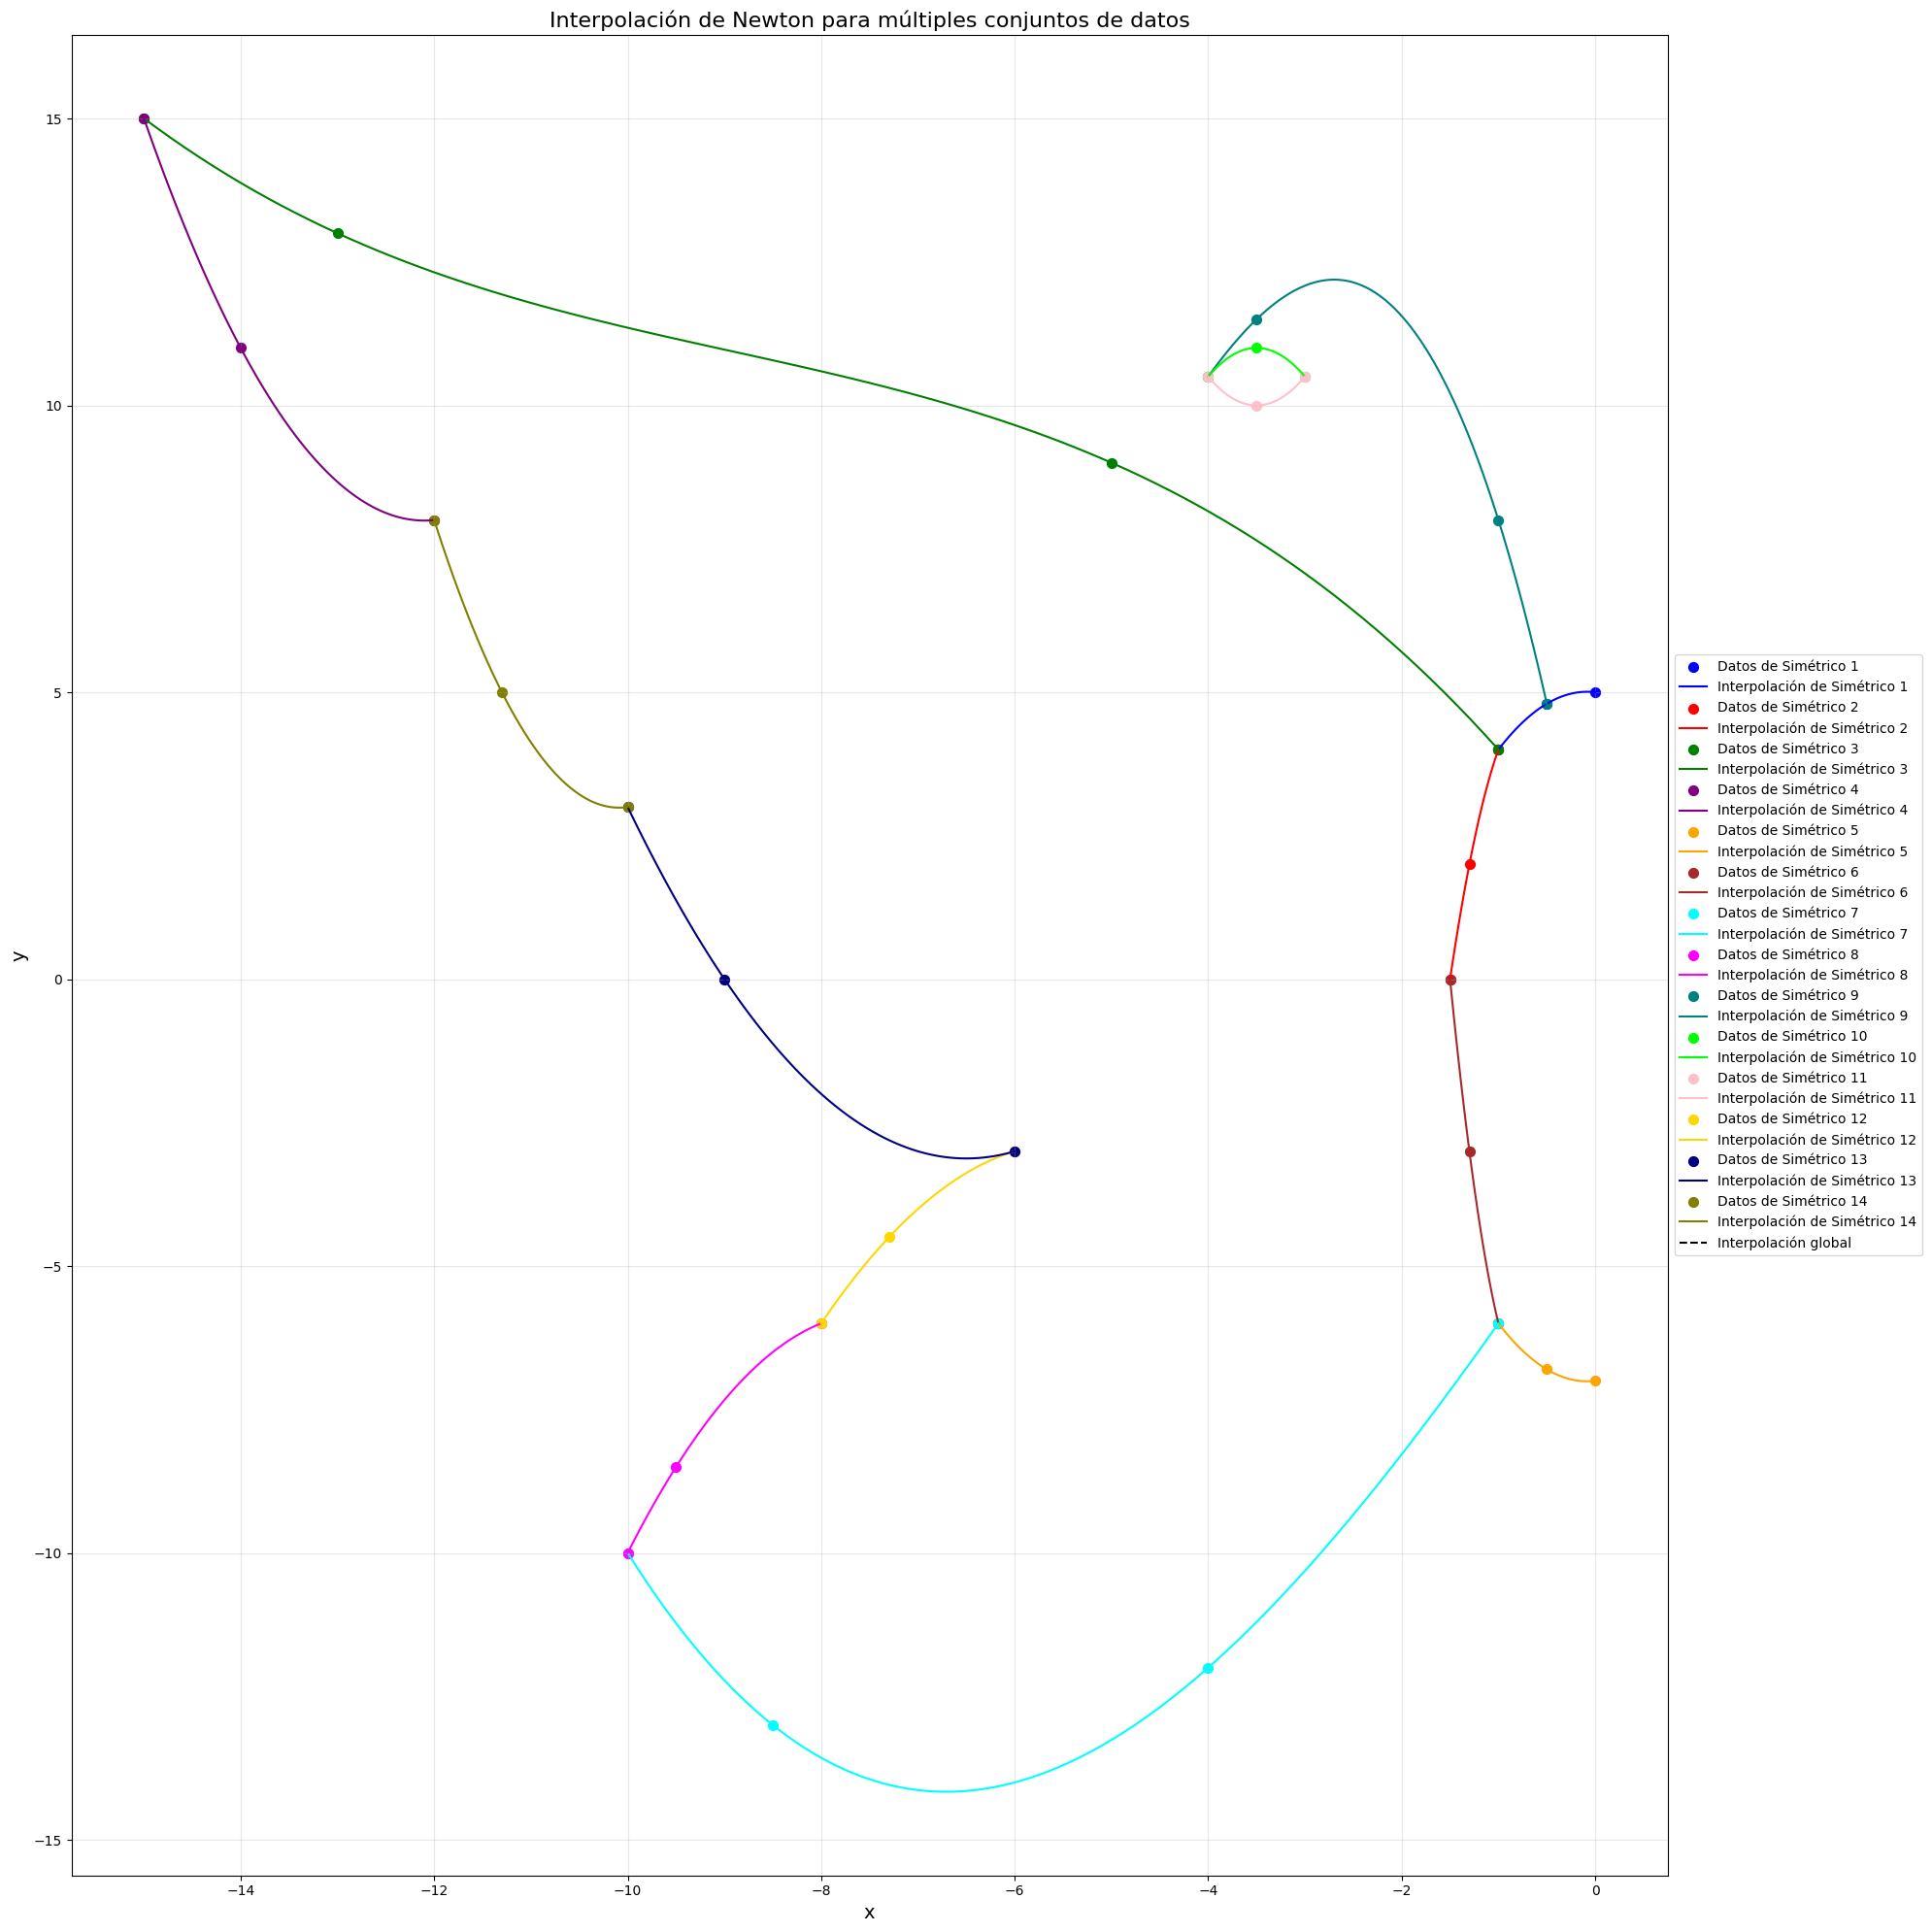

Polinomio de interpolación global (forma de Newton):
-7 + inf(x - 0.0) -inf(x - 0.0)(x - 0.0) + inf(x - 0.0)(x - 0.0)(x - 0.5) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.5)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.0)(x - 1.3) + nan(x - 0.0)(x - 0.0)(x - 0.5)(x - 0.5)(x - 0.

In [3]:
# Definir múltiples conjuntos de datos
datasets = [
    {
        'x': [0, 0.5, 1],
        'y': [5, 4.8, 4],
        'label': 'Conjunto 1',
        'color': 'blue'
    },
    {
        'x': [1, 1.3, 1.5],
        'y': [4, 2, 0],
        'label': 'Conjunto 2',
        'color': 'red'
    },
    {
        'x': [1, 5, 13, 15],
        'y': [4, 9, 13, 15],
        'label': 'Conjunto 3',
        'color': 'green'
    },
    {
        'x': [12, 14, 15],
        'y': [8, 11, 15],
        'label': 'Conjunto 4',
        'color': 'purple'
    },
    {
        'x': [0, 0.5, 1],
        'y': [-7, -6.8, -6],
        'label': 'Conjunto 5',
        'color': 'orange'
    },
    {
        'x': [1, 1.3, 1.5],
        'y': [-6, -3, 0],
        'label': 'Conjunto 6',
        'color': 'brown'
    },
    {
        'x': [1, 4, 8.5, 10],
        'y': [-6, -12, -13, -10],
        'label': 'Conjunto 7',
        'color': 'cyan'
    },
    {
        'x': [8, 9.5, 10],
        'y': [-6, -8.5, -10],
        'label': 'Conjunto 8',
        'color': 'magenta'
    },
    {
        'x': [0.5, 1, 3.5, 4],
        'y': [4.8, 8, 11.5, 10.5],
        'label': 'Conjunto 9',
        'color': 'teal'
    },
    {
        'x': [3, 3.5, 4],
        'y': [10.5, 11, 10.5],
        'label': 'Conjunto 10',
        'color': 'lime'
    },
    {
        'x': [3, 3.5, 4],
        'y': [10.5, 10, 10.5],
        'label': 'Conjunto 11',
        'color': 'pink'
    },
    {
        'x': [6, 7.3, 8],
        'y': [-3, -4.5, -6],
        'label': 'Conjunto 12',
        'color': 'gold'
    },
    {
        'x': [6, 9, 10],
        'y': [-3, 0, 3],
        'label': 'Conjunto 13',
        'color': 'navy'
    },
    {
        'x': [10, 11.3, 12],
        'y': [3, 5, 8],
        'label': 'Conjunto 14',
        'color': 'olive'
    },
]

# Crear conjuntos simétricos
symmetric_datasets = []
for i, data in enumerate(datasets):
    # Crear el conjunto simétrico con respecto al eje Y (cambiando el signo de X)
    symmetric_data = {
        'x': [-x for x in data['x']],
        'y': data['y'].copy(),
        'label': f'Simétrico {i+1}',
        'color': data['color']
    }
    symmetric_datasets.append(symmetric_data)

# Crear figura para la gráfica conjunta
fig, ax = plt.subplots(figsize=(20, 20))

# Para guardar los resultados numéricos
all_x_curve = []
all_y_curve = []
all_interpolators = []

# Procesar cada conjunto de datos usando Newton
for data in symmetric_datasets:
    # Crear un interpolador de Newton para cada conjunto
    newton = NewtonInterpolation(data['x'], data['y'])
    newton.compute_divided_differences()
    all_interpolators.append(newton)
    
    # Calcular puntos para la curva suave en el rango específico de este conjunto
    x_min, x_max = min(data['x']), max(data['x'])
    x_curve = np.linspace(x_min, x_max, 100)
    y_curve = newton.evaluate(x_curve)
    
    # Almacenar estos puntos para posible uso posterior
    all_x_curve.append(x_curve)
    all_y_curve.append(y_curve)
    
    # Graficar los puntos de datos
    ax.scatter(data['x'], data['y'], color=data['color'], 
               label=f'Datos de {data["label"]}', s=50)
    
    # Graficar la curva de interpolación
    ax.plot(x_curve, y_curve, '-', color=data['color'], 
            label=f'Interpolación de {data["label"]}')
    
    # Mostrar el polinomio en forma estándar
    standard_form = newton.get_standard_form_string()
    print(f"Polinomio de {data['label']} (forma de Newton):")
    print(newton.get_polynomial_string())
    print(f"\nPolinomio de {data['label']} (forma estándar):")
    print(standard_form)
    print("\n" + "-"*80 + "\n")

# Opcional: Interpolar todos los puntos juntos para comparar
all_x_points = []
all_y_points = []
for data in datasets:
    all_x_points.extend(data['x'])
    all_y_points.extend(data['y'])

# Ordenar los puntos combinados por x para evitar problemas
combined_points = sorted(zip(all_x_points, all_y_points))
all_x_sorted = [p[0] for p in combined_points]
all_y_sorted = [p[1] for p in combined_points]

# Crear un interpolador global con Newton
combined_newton = NewtonInterpolation(all_x_sorted, all_y_sorted)
combined_newton.compute_divided_differences()
x_full = np.linspace(min(all_x_sorted), max(all_x_sorted), 500)
y_full = combined_newton.evaluate(x_full)

# Graficar la interpolación global
ax.plot(x_full, y_full, 'k--', label='Interpolación global', linewidth=1.5)

# Configurar la gráfica
ax.grid(True, alpha=0.3)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_title('Interpolación de Newton para múltiples conjuntos de datos', fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Mostrar el polinomio global
print("Polinomio de interpolación global (forma de Newton):")
print(combined_newton.get_polynomial_string())
print("\nPolinomio de interpolación global (forma estándar):")
print(combined_newton.get_standard_form_string())

## Interpolación de Lagrange

In [9]:
class LagrangeInterpolation:
    """
    A class to perform Lagrange's interpolation method for polynomial fitting.
    """
    def __init__(self, x_points=None, y_points=None):
        """
        Initialize with optional data points.
        
        Parameters:
        -----------
        x_points : array-like, optional
            x coordinates of data points
        y_points : array-like, optional
            y coordinates of data points
        """
        self.x = None
        self.y = None
        self.L_polynomials = None
        self.polynomial = None
        
        if x_points is not None and y_points is not None:
            self.set_points(x_points, y_points)
    
    def set_points(self, x_points, y_points):
        """
        Set the data points to interpolate.
        
        Parameters:
        -----------
        x_points : array-like
            x coordinates of data points
        y_points : array-like
            y coordinates of data points
        """
        if len(x_points) != len(y_points):
            raise ValueError("x_points and y_points must have the same length")
            
        self.x = np.array(x_points, dtype=float)
        self.y = np.array(y_points, dtype=float)
        self.L_polynomials = None  # Reset Lagrange basis polynomials
        self.polynomial = None     # Reset interpolation polynomial
    
    def compute_lagrange_basis(self, i, x_val):
        """
        Compute the i-th Lagrange basis polynomial at a given x value.
        
        Parameters:
        -----------
        i : int
            Index of the Lagrange basis polynomial
        x_val : float or array-like
            Point(s) at which to evaluate the basis polynomial
        
        Returns:
        --------
        float or numpy.ndarray
            Value(s) of the i-th Lagrange basis polynomial at x_val
        """
        n = len(self.x)
        result = 1.0
        
        for j in range(n):
            if j != i:
                result = result * (x_val - self.x[j]) / (self.x[i] - self.x[j])
                
        return result
    
    def evaluate(self, x_eval):
        """
        Evaluate the Lagrange interpolation polynomial at given points.
        
        Parameters:
        -----------
        x_eval : float or array-like
            Points at which to evaluate the polynomial
        
        Returns:
        --------
        float or numpy.ndarray
            Value(s) of the polynomial at x_eval
        """
        # Convert input to numpy array if it's a scalar
        scalar_input = np.isscalar(x_eval)
        x_array = np.array([x_eval]) if scalar_input else np.array(x_eval)
        
        result = np.zeros_like(x_array, dtype=float)
        n = len(self.x)
        
        for i in range(len(x_array)):
            sum_val = 0.0
            for j in range(n):
                sum_val += self.y[j] * self.compute_lagrange_basis(j, x_array[i])
            result[i] = sum_val
            
        return result[0] if scalar_input else result
    
    def get_lagrange_basis_symbolic(self):
        """
        Get the symbolic expressions for all Lagrange basis polynomials.
        
        Returns:
        --------
        list of sympy expressions
            List of Lagrange basis polynomials in symbolic form
        """
        x = sp.Symbol('x')
        n = len(self.x)
        L_polynomials = []
        
        for i in range(n):
            L_i = 1
            for j in range(n):
                if j != i:
                    L_i *= (x - self.x[j]) / (self.x[i] - self.x[j])
            L_polynomials.append(L_i)
            
        self.L_polynomials = L_polynomials
        return L_polynomials
    
    def get_polynomial_symbolic(self):
        """
        Get the symbolic expression for the full Lagrange interpolation polynomial.
        
        Returns:
        --------
        sympy expression
            Symbolic form of the Lagrange polynomial
        """
        if self.L_polynomials is None:
            self.get_lagrange_basis_symbolic()
            
        polynomial = 0
        for i, L_i in enumerate(self.L_polynomials):
            polynomial += self.y[i] * L_i
            
        self.polynomial = polynomial
        return polynomial
    
    def get_polynomial_terms(self):
        """
        Get the terms of the Lagrange form polynomial.
        
        Returns:
        --------
        list of strings
            Terms of the Lagrange polynomial in readable form
        """
        if self.L_polynomials is None:
            self.get_lagrange_basis_symbolic()
            
        terms = []
        
        for i, basis in enumerate(self.L_polynomials):
            term = f"{self.y[i]} * L_{i}(x)"
            terms.append(term)
            
        return terms
    
    def get_polynomial_string(self):
        """
        Get the Lagrange interpolation polynomial as a readable string.
        
        Returns:
        --------
        str
            String representation of the Lagrange polynomial
        """
        terms = self.get_polynomial_terms()
        
        # Join terms with appropriate signs
        polynomial = terms[0]
        for term in terms[1:]:
            polynomial += f" + {term}"
                
        return polynomial
    
    def get_standard_form_symbolic(self):
        """
        Convert the Lagrange form to standard form using sympy.
        
        Returns:
        --------
        sympy expression
            Standard form of the polynomial
        """
        if self.polynomial is None:
            self.get_polynomial_symbolic()
            
        # Expand to standard form
        expanded_poly = sp.expand(self.polynomial)
        
        return expanded_poly
    
    def get_standard_form_string(self):
        """
        Get the standard form of the polynomial as a string.
        
        Returns:
        --------
        str
            String representation of the polynomial in standard form
        """
        expanded_poly = self.get_standard_form_symbolic()
        return str(expanded_poly)
    
    def get_standard_form_latex(self):
        """
        Get the standard form of the polynomial in LaTeX format.
        
        Returns:
        --------
        str
            LaTeX representation of the polynomial in standard form
        """
        expanded_poly = self.get_standard_form_symbolic()
        return sp.latex(expanded_poly)
    
    def plot_interpolation(self, x_range=None, num_points=1000):
        """
        Plot the data points and the interpolation polynomial.
        
        Parameters:
        -----------
        x_range : tuple, optional
            Range (x_min, x_max) for plotting the polynomial
        num_points : int, optional
            Number of points to use for plotting the smooth curve
        
        Returns:
        --------
        matplotlib figure
        """
        if x_range is None:
            # Extend range slightly beyond data points
            x_min, x_max = min(self.x), max(self.x)
            margin = (x_max - x_min) * 0.1
            x_range = (x_min - margin, x_max + margin)
            
        # Generate points for smooth curve
        x_curve = np.linspace(x_range[0], x_range[1], num_points)
        y_curve = self.evaluate(x_curve)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot the data points
        ax.scatter(self.x, self.y, color='red', s=50, label='Puntos de datos')
        
        # Plot the interpolation curve
        ax.plot(x_curve, y_curve, 'b-', label='Polinomio de interpolación')
        
        # Add grid and labels
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Interpolación de Lagrange')
        ax.legend()
        
        return fig
    
    def display_lagrange_basis(self, x_range=None, num_points=1000):
        """
        Plot each Lagrange basis polynomial.
        
        Parameters:
        -----------
        x_range : tuple, optional
            Range (x_min, x_max) for plotting
        num_points : int, optional
            Number of points to use for plotting the smooth curves
        
        Returns:
        --------
        matplotlib figure
        """
        if x_range is None:
            # Extend range slightly beyond data points
            x_min, x_max = min(self.x), max(self.x)
            margin = (x_max - x_min) * 0.1
            x_range = (x_min - margin, x_max + margin)
            
        # Generate points for smooth curves
        x_curve = np.linspace(x_range[0], x_range[1], num_points)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot each Lagrange basis polynomial
        for i in range(len(self.x)):
            y_basis = np.array([self.compute_lagrange_basis(i, x) for x in x_curve])
            ax.plot(x_curve, y_basis, label=f'L_{i}(x)')
            
        # Plot the data points
        ax.scatter(self.x, np.ones_like(self.x), color='red', s=50)
        
        # Add grid and labels
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('x')
        ax.set_ylabel('L_i(x)')
        ax.set_title('Polinomios base de Lagrange')
        ax.legend()
        
        return fig
    
    def get_error_formula(self, x_eval):
        """
        Get a symbolic representation of the error formula for Lagrange interpolation.
        
        Parameters:
        -----------
        x_eval : float
            Point at which to evaluate the error formula
        
        Returns:
        --------
        str
            Symbolic representation of the error formula
        """
        n = len(self.x)
        
        # Create the product term (x - x_0)(x - x_1)...(x - x_{n-1})
        product = f"(ξ)"
        for i in range(n):
            if self.x[i] >= 0:
                product += f"(x - {self.x[i]})"
            else:
                product += f"(x + {-self.x[i]})"
        
        # Create the error formula f^(n)(ξ)/n! * product
        error_formula = f"f^({n})(ξ)/{n}! * {product}"
        
        return error_formula
    
    def get_error_bounds(self, x_eval, max_derivative):
        """
        Estimate error bounds for the interpolation at given points.
        
        Parameters:
        -----------
        x_eval : float or array-like
            Points at which to estimate error bounds
        max_derivative : float
            Maximum absolute value of the n-th derivative in the interval
        
        Returns:
        --------
        float or numpy.ndarray
            Estimated upper bounds of the error
        """
        n = len(self.x)
        
        # Convert input to numpy array if it's a scalar
        scalar_input = np.isscalar(x_eval)
        x_array = np.array([x_eval]) if scalar_input else np.array(x_eval)
        
        error_bounds = np.zeros_like(x_array, dtype=float)
        
        for i in range(len(x_array)):
            # Calculate product term (x - x_0)(x - x_1)...(x - x_{n-1})
            product = 1.0
            for j in range(n):
                product *= (x_array[i] - self.x[j])
                
            # Calculate factorial n!
            factorial_n = np.math.factorial(n)
            
            # Calculate error bound
            error_bounds[i] = abs(product) * max_derivative / factorial_n
            
        return error_bounds[0] if scalar_input else error_bounds

Polinomio en forma simbólica:
9.6*x*(2.0 - 2.0*x) + 4.0*x*(2.0*x - 1.0) + 5.0*(1.0 - 2.0*x)*(1.0 - 1.0*x)
Polinomio en forma estándar:
-1.2*x**2 + 0.199999999999999*x + 5.0


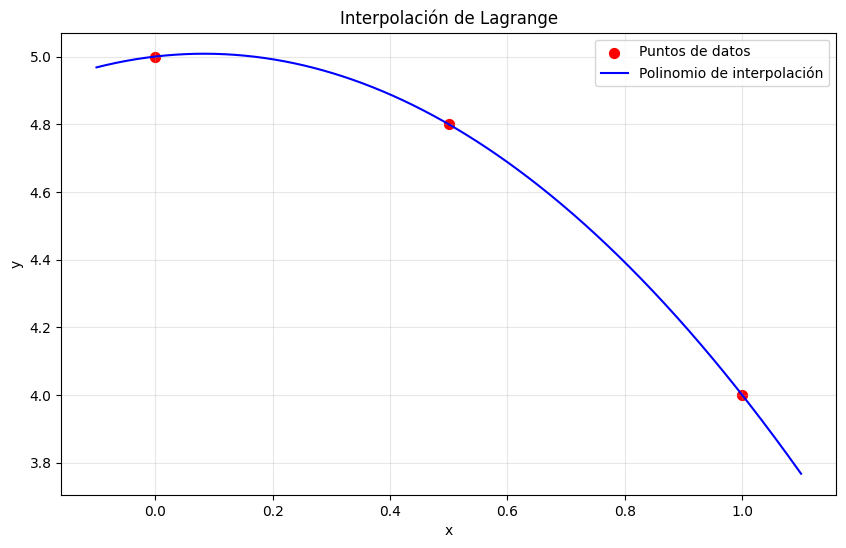

In [11]:
x_points = [0, 0.5, 1]
y_points = [5, 4.8, 4]

# Crear una instancia de interpolación de Lagrange
lagrange = LagrangeInterpolation(x_points, y_points)

# Obtener la forma simbólica del polinomio
poly_symbolic = lagrange.get_polynomial_symbolic()
print("Polinomio en forma simbólica:")
print(poly_symbolic)

# Obtener la forma estándar del polinomio
standard_form = lagrange.get_standard_form_symbolic()
print("Polinomio en forma estándar:")
print(standard_form)

# Graficar la interpolación
fig = lagrange.plot_interpolation()
plt.title("Interpolación de Lagrange")
plt.show()

Polinomio de Conjunto 1 (forma estándar):
-1.2*x**2 + 0.199999999999999*x + 5.0

Polinomio de Conjunto 2 (forma estándar):
-6.66666666666667*x**2 + 8.66666666666669*x + 1.99999999999999

Polinomio de Conjunto 3 (forma estándar):
0.00803571428571429*x**3 - 0.215178571428571*x**2 + 2.29196428571429*x + 1.91517857142857

Polinomio de Conjunto 4 (forma estándar):
0.833333333333333*x**2 - 20.1666666666667*x + 130.0

Polinomio de Conjunto 5 (forma estándar):
1.2*x**2 - 0.199999999999999*x - 7.0

Polinomio de Conjunto 6 (forma estándar):
10.0*x**2 - 13.0*x - 2.99999999999999

Polinomio de Conjunto 7 (forma estándar):
0.0148148148148148*x**3 + 0.0370370370370368*x**2 - 2.49629629629629*x - 3.55555555555556

Polinomio de Conjunto 8 (forma estándar):
-0.666666666666668*x**2 + 10.0*x - 43.3333333333334

Polinomio de Conjunto 9 (forma estándar):
0.152380952380952*x**3 - 2.42857142857143*x**2 + 9.77619047619048*x + 0.499999999999996

Polinomio de Conjunto 10 (forma estándar):
-2.0*x**2 + 14.0*x - 1

/tmp/ipykernel_912/3342217994.py:64: RuntimeWarning: invalid value encountered in scalar divide
  result = result * (x_val - self.x[j]) / (self.x[i] - self.x[j])
/tmp/ipykernel_912/3342217994.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  result = result * (x_val - self.x[j]) / (self.x[i] - self.x[j])
/tmp/ipykernel_912/3342217994.py:92: RuntimeWarning: invalid value encountered in scalar add
  sum_val += self.y[j] * self.compute_lagrange_basis(j, x_array[i])
/tmp/ipykernel_912/3342217994.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  sum_val += self.y[j] * self.compute_lagrange_basis(j, x_array[i])
/tmp/ipykernel_912/3342217994.py:64: RuntimeWarning: invalid value encountered in scalar multiply
  result = result * (x_val - self.x[j]) / (self.x[i] - self.x[j])


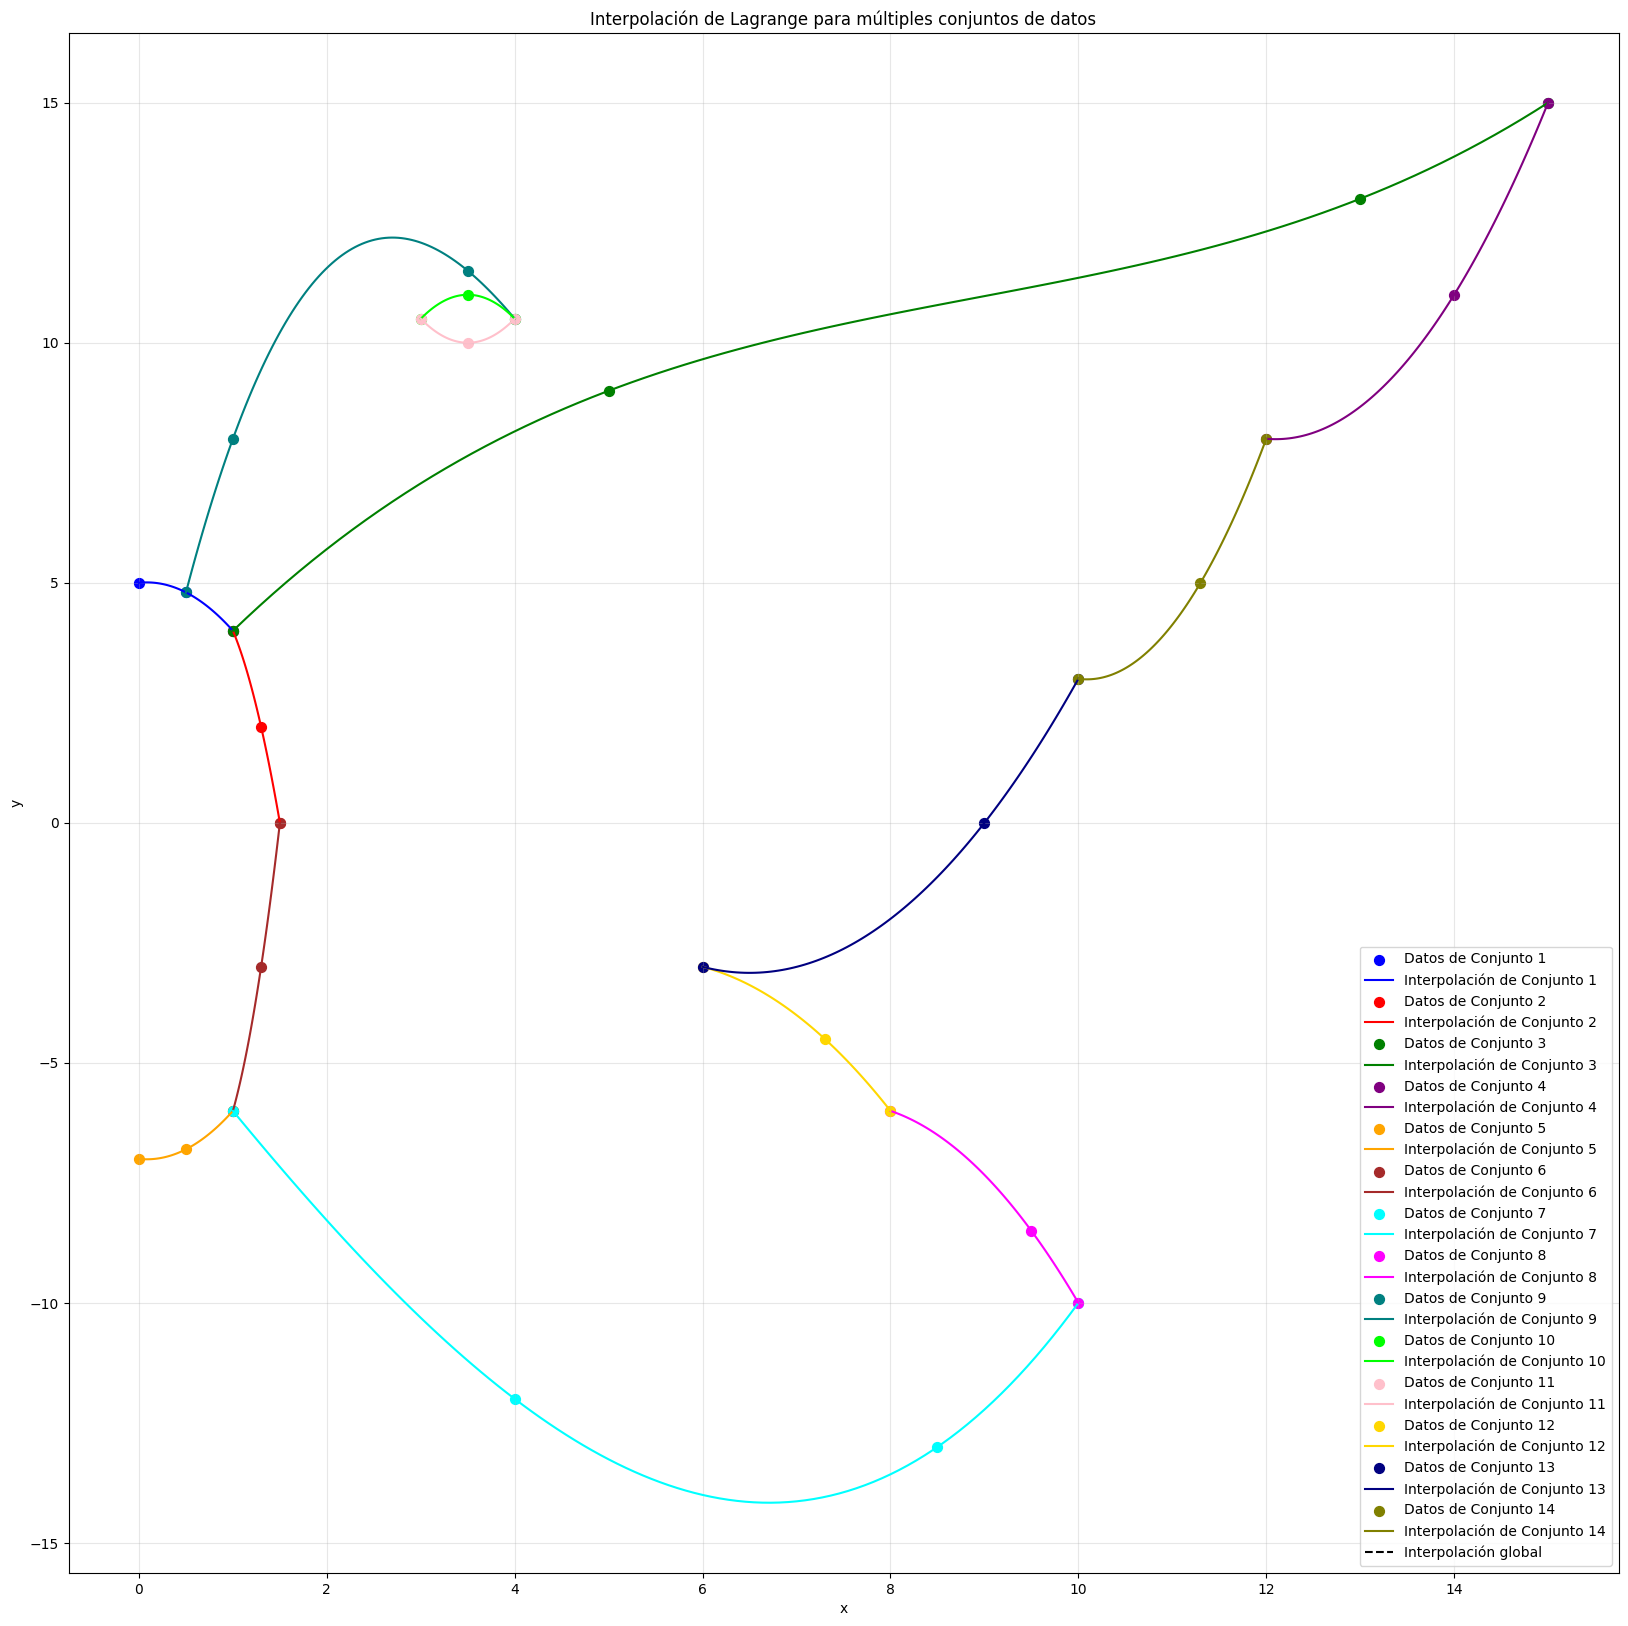

Polinomio de interpolación global (forma estándar):
nan


In [13]:
# Definir múltiples conjuntos de datos
datasets = [
    {
        'x': [0, 0.5, 1],
        'y': [5, 4.8, 4],
        'label': 'Conjunto 1',
        'color': 'blue'
    },
    {
        'x': [1, 1.3, 1.5],
        'y': [4, 2, 0],
        'label': 'Conjunto 2',
        'color': 'red'
    },
    {
        'x': [1, 5, 13, 15],
        'y': [4, 9, 13, 15],
        'label': 'Conjunto 3',
        'color': 'green'
    },
    {
        'x': [12, 14, 15],
        'y': [8, 11, 15],
        'label': 'Conjunto 4',
        'color': 'purple'
    },
    {
        'x': [0, 0.5, 1],
        'y': [-7, -6.8, -6],
        'label': 'Conjunto 5',
        'color': 'orange'
    },
    {
        'x': [1, 1.3, 1.5],
        'y': [-6, -3, 0],
        'label': 'Conjunto 6',
        'color': 'brown'
    },
    {
        'x': [1, 4, 8.5, 10],
        'y': [-6, -12, -13, -10],
        'label': 'Conjunto 7',
        'color': 'cyan'
    },
    {
        'x': [8, 9.5, 10],
        'y': [-6, -8.5, -10],
        'label': 'Conjunto 8',
        'color': 'magenta'
    },
    {
        'x': [0.5, 1, 3.5, 4],
        'y': [4.8, 8, 11.5, 10.5],
        'label': 'Conjunto 9',
        'color': 'teal'
    },
    {
        'x': [3, 3.5, 4],
        'y': [10.5, 11, 10.5],
        'label': 'Conjunto 10',
        'color': 'lime'
    },
    {
        'x': [3, 3.5, 4],
        'y': [10.5, 10, 10.5],
        'label': 'Conjunto 11',
        'color': 'pink'
    },
    {
        'x': [6, 7.3, 8],
        'y': [-3, -4.5, -6],
        'label': 'Conjunto 12',
        'color': 'gold'
    },
    {
        'x': [6, 9, 10],
        'y': [-3, 0, 3],
        'label': 'Conjunto 13',
        'color': 'navy'
    },
    {
        'x': [10, 11.3, 12],
        'y': [3, 5, 8],
        'label': 'Conjunto 14',
        'color': 'olive'
    },
]

# Crear figura para la gráfica conjunta
fig, ax = plt.subplots(figsize=(20, 20))

# Para guardar los resultados numéricos
all_x_curve = []
all_y_curve = []
all_interpolators = []

# Procesar cada conjunto de datos
for data in datasets:
    # Crear un interpolador para cada conjunto
    interpolator = LagrangeInterpolation(data['x'], data['y'])
    all_interpolators.append(interpolator)
    
    # Calcular puntos para la curva suave en el rango específico de este conjunto
    x_min, x_max = min(data['x']), max(data['x'])
    x_curve = np.linspace(x_min, x_max, 100)
    y_curve = interpolator.evaluate(x_curve)
    
    # Almacenar estos puntos para posible uso posterior
    all_x_curve.append(x_curve)
    all_y_curve.append(y_curve)
    
    # Graficar los puntos de datos
    ax.scatter(data['x'], data['y'], color=data['color'], 
               label=f'Datos de {data["label"]}', s=50)
    
    # Graficar la curva de interpolación
    ax.plot(x_curve, y_curve, '-', color=data['color'], 
            label=f'Interpolación de {data["label"]}')
    
    # Mostrar el polinomio en forma estándar
    standard_form = interpolator.get_standard_form_string()
    print(f"Polinomio de {data['label']} (forma estándar):")
    print(standard_form)
    print()

# Opcional: Interpolar todos los puntos juntos para comparar
all_x_points = []
all_y_points = []
for data in datasets:
    all_x_points.extend(data['x'])
    all_y_points.extend(data['y'])

# Ordenar los puntos combinados por x para evitar problemas
combined_points = sorted(zip(all_x_points, all_y_points))
all_x_sorted = [p[0] for p in combined_points]
all_y_sorted = [p[1] for p in combined_points]

# Crear un interpolador para todos los puntos juntos
combined_interpolator = LagrangeInterpolation(all_x_sorted, all_y_sorted)
x_full = np.linspace(min(all_x_sorted), max(all_x_sorted), 500)
y_full = combined_interpolator.evaluate(x_full)

# Graficar la interpolación combinada
ax.plot(x_full, y_full, 'k--', label='Interpolación global', linewidth=1.5)

# Configurar la gráfica
ax.grid(True, alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Interpolación de Lagrange para múltiples conjuntos de datos')
ax.legend()

plt.show()

# Mostrar el polinomio combinado
print("Polinomio de interpolación global (forma estándar):")
print(combined_interpolator.get_standard_form_string())

Tablas de simétricos
x: [0, -0.5, -1]
y: [5, 4.8, 4]
x: [-1, -1.3, -1.5]
y: [4, 2, 0]
x: [-1, -5, -13, -15]
y: [4, 9, 13, 15]
x: [-12, -14, -15]
y: [8, 11, 15]
x: [0, -0.5, -1]
y: [-7, -6.8, -6]
x: [-1, -1.3, -1.5]
y: [-6, -3, 0]
x: [-1, -4, -8.5, -10]
y: [-6, -12, -13, -10]
x: [-8, -9.5, -10]
y: [-6, -8.5, -10]
x: [-0.5, -1, -3.5, -4]
y: [4.8, 8, 11.5, 10.5]
x: [-3, -3.5, -4]
y: [10.5, 11, 10.5]
x: [-3, -3.5, -4]
y: [10.5, 10, 10.5]
x: [-6, -7.3, -8]
y: [-3, -4.5, -6]
x: [-6, -9, -10]
y: [-3, 0, 3]
x: [-10, -11.3, -12]
y: [3, 5, 8]
Polinomio de Conjunto 1 (forma estándar):
-1.2*x**2 + 0.199999999999999*x + 5.0

Polinomio de Conjunto 2 (forma estándar):
-6.66666666666667*x**2 + 8.66666666666669*x + 1.99999999999999

Polinomio de Conjunto 3 (forma estándar):
0.00803571428571429*x**3 - 0.215178571428571*x**2 + 2.29196428571429*x + 1.91517857142857

Polinomio de Conjunto 4 (forma estándar):
0.833333333333333*x**2 - 20.1666666666667*x + 130.0

Polinomio de Conjunto 5 (forma estándar):
1.2*

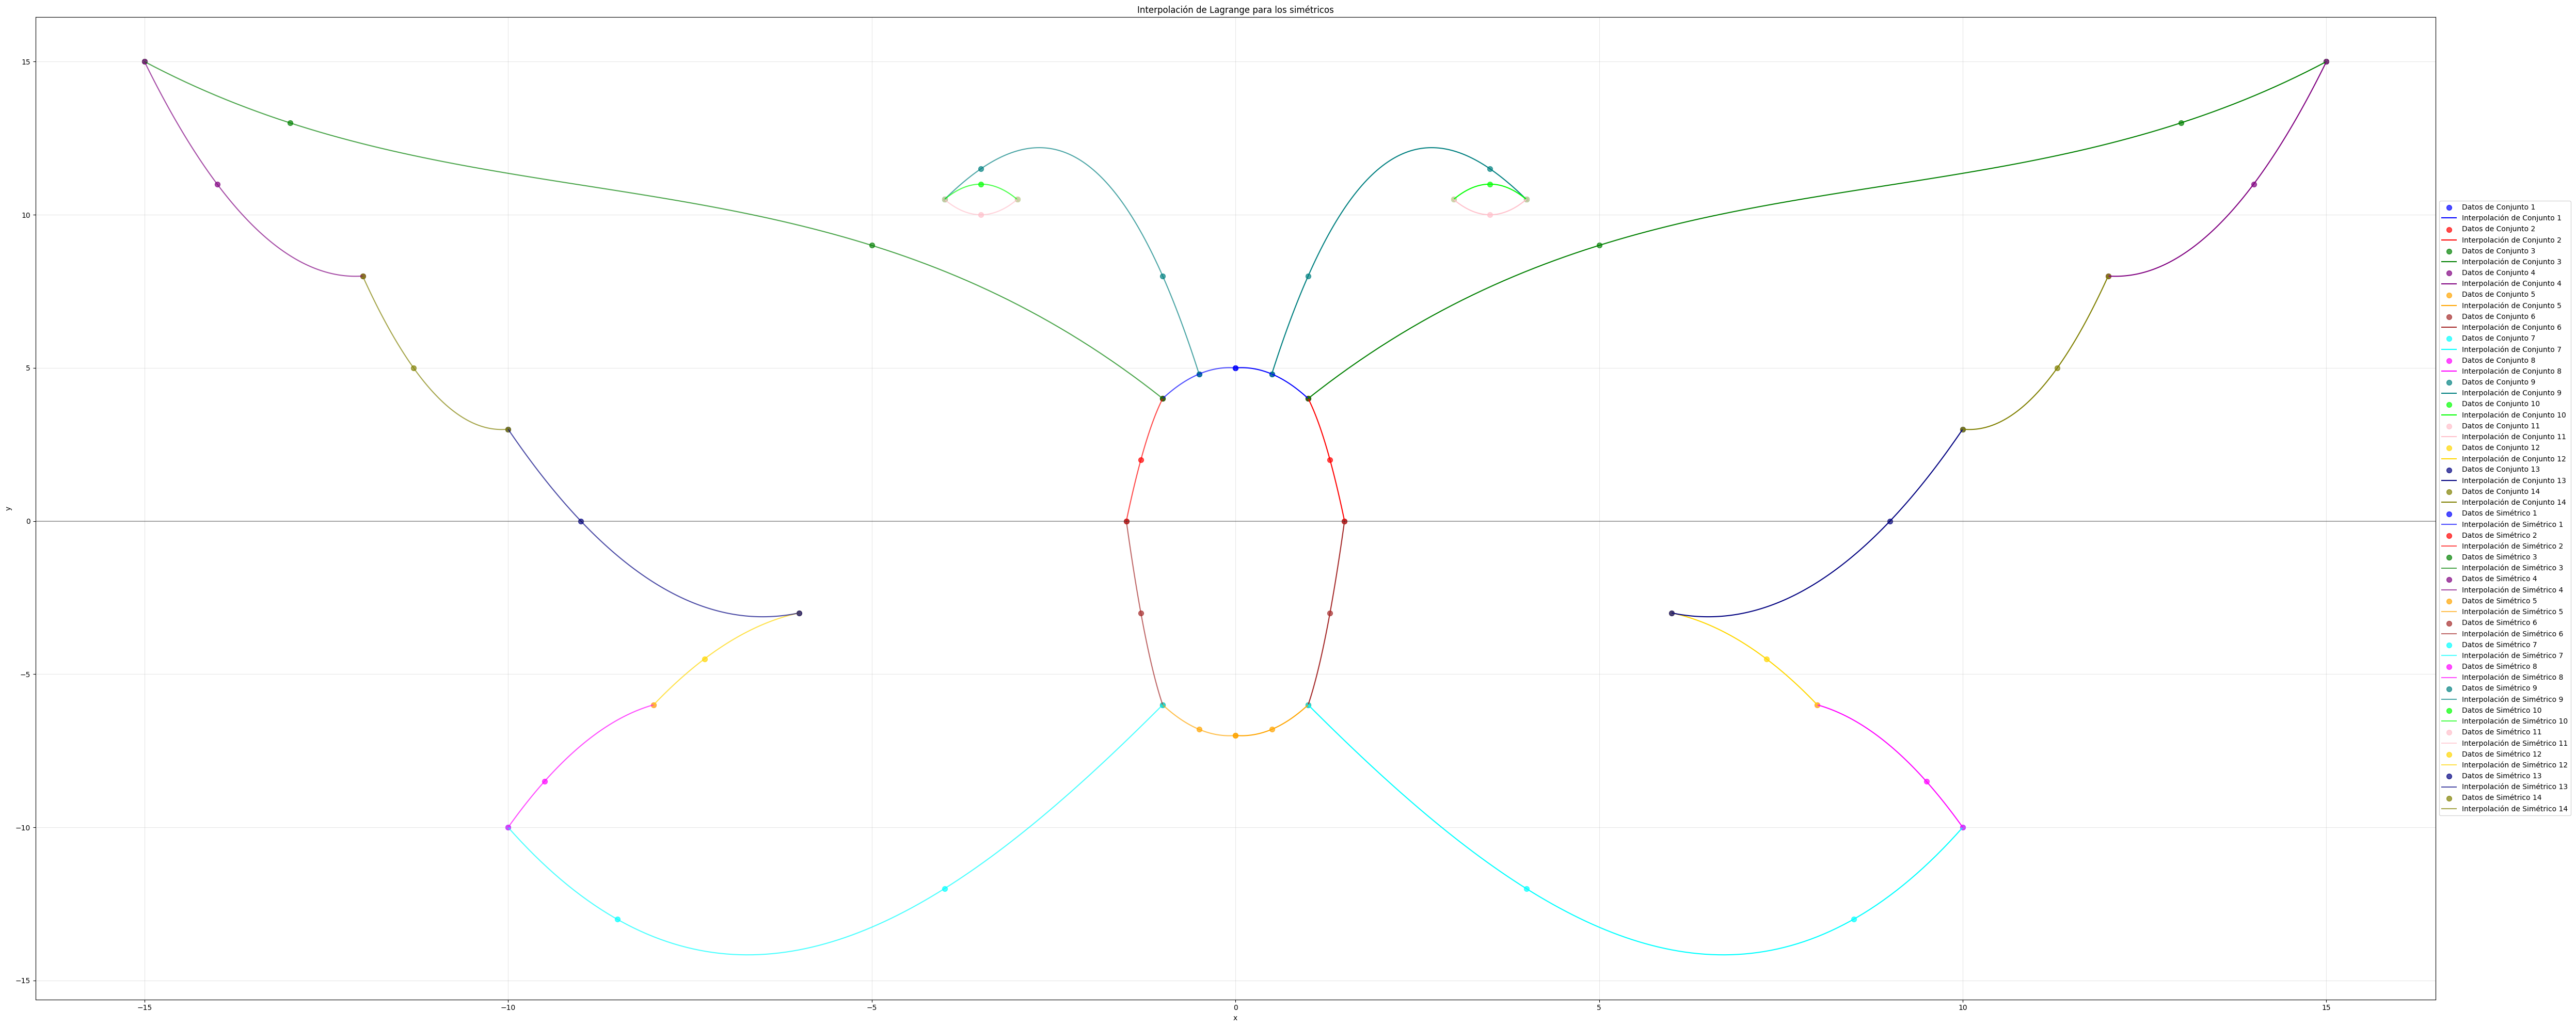

In [21]:
# Definir múltiples conjuntos de datos
datasets = [
    {
        'x': [0, 0.5, 1],
        'y': [5, 4.8, 4],
        'label': 'Conjunto 1',
        'color': 'blue'
    },
    {
        'x': [1, 1.3, 1.5],
        'y': [4, 2, 0],
        'label': 'Conjunto 2',
        'color': 'red'
    },
    {
        'x': [1, 5, 13, 15],
        'y': [4, 9, 13, 15],
        'label': 'Conjunto 3',
        'color': 'green'
    },
    {
        'x': [12, 14, 15],
        'y': [8, 11, 15],
        'label': 'Conjunto 4',
        'color': 'purple'
    },
    {
        'x': [0, 0.5, 1],
        'y': [-7, -6.8, -6],
        'label': 'Conjunto 5',
        'color': 'orange'
    },
    {
        'x': [1, 1.3, 1.5],
        'y': [-6, -3, 0],
        'label': 'Conjunto 6',
        'color': 'brown'
    },
    {
        'x': [1, 4, 8.5, 10],
        'y': [-6, -12, -13, -10],
        'label': 'Conjunto 7',
        'color': 'cyan'
    },
    {
        'x': [8, 9.5, 10],
        'y': [-6, -8.5, -10],
        'label': 'Conjunto 8',
        'color': 'magenta'
    },
    {
        'x': [0.5, 1, 3.5, 4],
        'y': [4.8, 8, 11.5, 10.5],
        'label': 'Conjunto 9',
        'color': 'teal'
    },
    {
        'x': [3, 3.5, 4],
        'y': [10.5, 11, 10.5],
        'label': 'Conjunto 10',
        'color': 'lime'
    },
    {
        'x': [3, 3.5, 4],
        'y': [10.5, 10, 10.5],
        'label': 'Conjunto 11',
        'color': 'pink'
    },
    {
        'x': [6, 7.3, 8],
        'y': [-3, -4.5, -6],
        'label': 'Conjunto 12',
        'color': 'gold'
    },
    {
        'x': [6, 9, 10],
        'y': [-3, 0, 3],
        'label': 'Conjunto 13',
        'color': 'navy'
    },
    {
        'x': [10, 11.3, 12],
        'y': [3, 5, 8],
        'label': 'Conjunto 14',
        'color': 'olive'
    },
]

# Crear conjuntos simétricos
symmetric_datasets = []
for i, data in enumerate(datasets):
    # Crear el conjunto simétrico con respecto al eje Y (cambiando el signo de X)
    symmetric_data = {
        'x': [-x for x in data['x']],
        'y': data['y'].copy(),
        'label': f'Simétrico {i+1}',
        'color': data['color']
    }
    symmetric_datasets.append(symmetric_data)

print("Tablas de simétricos")
# Imprimir tablas simétricas
[print(f"x: {i['x']}\ny: {i['y']}") for i in symmetric_datasets ]

# Combinar conjuntos originales y simétricos
all_datasets = datasets + symmetric_datasets

# Configurar el tamaño de la figura
plt.figure(figsize=(50, 20))

# Graficar todos los conjuntos
for data in all_datasets:
    # Crear un interpolador de Lagrange para este conjunto
    interpolator = LagrangeInterpolation(data['x'], data['y'])
    
    # Calcular puntos para la curva suave
    x_min, x_max = min(data['x']), max(data['x'])
    x_curve = np.linspace(x_min, x_max, 100)
    y_curve = interpolator.evaluate(x_curve)
    
    # Graficar los puntos de datos
    plt.scatter(data['x'], data['y'], color=data['color'], 
               label=f'Datos de {data["label"]}', s=50, alpha=0.7)
    
    # Graficar la curva de interpolación
    if 'Simétrico' in data['label']:
        plt.plot(x_curve, y_curve, color=data['color'], 
                label=f'Interpolación de {data["label"]}', alpha=0.7)
    else:
        plt.plot(x_curve, y_curve, color=data['color'], 
                label=f'Interpolación de {data["label"]}')
    
    # Mostrar el polinomio en forma estándar
    standard_form = interpolator.get_standard_form_string()
    print(f"Polinomio de {data['label']} (forma estándar):")
    print(standard_form)
    print()

# Añadir una línea horizontal en y=0 para visualizar mejor la simetría
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Configurar la gráfica
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolación de Lagrange para los simétricos')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()